In [426]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from itertools import compress
import random

from scipy.signal import stft, istft
from scipy.signal.windows import hann, gaussian
from scipy.special import gamma
from scipy.optimize import curve_fit
import pywt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import math
from sklearn.linear_model import LinearRegression
import numbers
from time import sleep


In [427]:
# Control variables to be put here to be varied?
time_win = 5
sc_factor = 1
signal_rate = 7.81


In [428]:
# Preparing the dataset that we're going to use
fnirs_folder = mne.datasets.fnirs_motor.data_path()
fnirs_cw_amplitude_dir = fnirs_folder / "Participant-1"
raw_intensity = mne.io.read_raw_nirx(fnirs_cw_amplitude_dir, verbose=True)
raw_intensity.load_data()



raw_intensity.annotations.set_durations(time_win)
raw_intensity.annotations.rename(
    {"1.0": "Control", "2.0": "Tapping/Left", "3.0": "Tapping/Right"}
)
unwanted = np.nonzero(raw_intensity.annotations.description == "15.0")
raw_intensity.annotations.delete(unwanted)
# Apparently channel 15 is unrelated to the motor activation experiment,
# it was used to signal something unrelated and so will be ignored



# Removes short channels
picks = mne.pick_types(raw_intensity.info, meg = False, fnirs = True)
dists = mne.preprocessing.nirs.source_detector_distances(
    raw_intensity.info, picks = picks)
raw_intensity.pick(picks[dists > 0.01])



# Converting to optical density based on readings, then to haemo readings
raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od, ppf=6)

# We filter them to remove the frequencies associated with cardiac activity (unrelated)
raw_haemo_unfiltered = raw_haemo.copy()
raw_haemo.filter(0.05, 0.7, h_trans_bandwidth = 0.2, l_trans_bandwidth = 0.02)



# Creates epochs for each occurence of an event (Left tap, right tap, control)
reject_criteria = dict(hbo=80e-6)
tmin, tmax = -1, 25
events, event_dict = mne.events_from_annotations(raw_haemo)


epochs = mne.Epochs(
    raw_haemo,
    events,
    event_id=event_dict,
    tmin=tmin,
    tmax=tmax,
    reject=reject_criteria,
    reject_by_annotation=True,
    proj=True,
    baseline=(None, 0),
    preload=True,
    detrend=None,
    verbose=True,
)

isolated_event_epochs = epochs["Tapping"]
control_event_set = epochs["Control"]
isol_dhrf_data = isolated_event_epochs.get_data(copy=True)
avg_haemo_func_tapping = isolated_event_epochs.average()
std_dev = np.std(avg_haemo_func_tapping.data, axis=0)

Loading /Users/kostasdemiris/mne_data/MNE-fNIRS-motor-data/Participant-1
Reading 0 ... 23238  =      0.000 ...  2974.464 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1291 samples (165.248 s)

Used Annotations descriptions: ['Control', 'Tapping/Left', 'Tapping/Right']
Not setting metadata
90 matching events found
Setting baseline interval to [-1.024, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 90 events and 204 original time po

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished


In [429]:
# Conversion between the different forms i need, including for display purposes.
class convs:
    def __init__(self):
        pass
    
    def apply_stft(self, signal, sample_rate):
        window = gaussian(128, std = 7)
        hop = 128
        # returns in the format: frequency, time, result
        return stft(signal, sample_rate, nperseg = 64)
    
    def wavelet_decmp(self, signal, m_wavelet, d_level):
         return pywt.wavedec(signal, m_wavelet, d_level)
    
    def i_wavelet_decmp(self, coeffs, m_wavelet):
        return pywt.waverec(coeffs, m_wavelet)
    
    def inv_WvImg_conv(self, wvImg, arr_shape, minim_data, maxim_data):
        # Firstly seperate it into channels, for each row of pixels
        # remove all padded values, un-normalise then inverse_wavelet_conv
        un_padded = []
        un_norm = rev_normalise(wvImg, minim_data, maxim_data)
        for row in un_norm:
            un_padded.append(self.i_wavelet_decmp(rem_padding(row, arr_shape), wavelet))
        return un_padded
    
    def padarray(self, arr, size): 
        return np.pad(arr, pad_width=(0, size-len(arr)), mode='constant')
    
    def rem_padding(self, arr, arr_shape):
        original_array = []
        sec = max(arr_shape)
        start_i = 0
        while start_i * sec < len(arr) - 1:
            original_array.append(arr[start_i * sec : (start_i * sec) + arr_shape[start_i]])
            start_i += 1
        return original_array
    
    def normalise(self, arr, scale_factor=sc_factor):
        data_min = np.min(arr)
        data_max = np.max(arr)
        return ((arr - data_min) / (data_max - data_min)) * scale_factor

    def rev_normalise(self, arr, n_min, n_max, scale_factor=sc_factor):
        return (((arr-1)/scale_factor) * (n_max - n_min)) + n_min
    
    # Not necessary if using the base normalise function, just for testing
    def event_to_wvImg(self, sample, wavelet, level, min_n, max_n):
        wv_channel_arr = []
        for channel in sample:
            wv_form = convs.wavelet_decmp(channel, wavelet, level)
            maxim_len = max(len(sub_arr) for sub_arr in wv_form)
            wv_channel_arr.append(np.array([padarray(arr, maxim_len) for arr in wv_form]).flatten())
        wv_channel_arr = np.array(wv_channel_arr)
        normalised = sc_factor * (wv_channel_arr - min_n) / ( max_n - min_n)
        normalised[wv_channel_arr == 0] = -1
        return normalised
    
    def convert_signal(self, signal):
        decomposed = convs.wavelet_decmp(signal, wavelet, level)
        pad_decomp = np.array([padarray(a[i], len(a[len(a)-1])) for i in range(len(a))]).flatten()
        return pad_decomp

    def reverse_conversion(self, signal, sig_min, sig_max, sub_arr_lens):
        unNorm = rev_normalise(signal, sig_min, sig_max)
        unpadded_Ver = rem_padding(unNorm, sub_arr_lens)
        return convs.i_wavelet_decmp(unpadded_Ver, wavelet)
    
    def z_curve_normalisation(self, data):
        mean = np.mean(data)
        std = np.std(data)
        return (data - mean) / std

    def inv_z_curve_normalisation(self, data, mean, std):
        return (data * std) + mean
    

convs = convs()

In [485]:
class display:
    def __init__(self, time_sig):
        self.time_signal = time_sig
    
    def display_gray_arr(self, img_arr):
        plt.imshow(img_arr, cmap='gray')
        plt.title("Wavelet As Image")
        plt.axis('off')
        plt.show()
    
    def plot_pChannel(self, points, time_series):
        plt.figure(figsize=(10, 4))
        plt.plot(time_series, points)
        plt.title("channel")
        plt.xlabel("Time [s]")
        plt.ylabel("Amplitude")
        plt.show()
    
    def plot_scatter_data(self, data_points, central=0.5):
        plt.scatter([i for i in range(len(data_points))], data_points, color='white', alpha=0.5)

        for i in range(len(data_points)):
            plt.plot([i, i], [data_points[i], central], color='red', alpha=0.5)

        plt.axhline(y=central, color='green', linestyle='--')

        plt.title('Scatter Plot')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.grid(True)
        plt.show()
    

time_signal = np.arange(len(avg_haemo_func_tapping.data[0])) * (1/signal_rate)      
displays = display(time_signal)

In [431]:
# The actual conversion of the data to wavelet form and so forth, for the 60 original signals

wavelet = 'sym4' # Resembles cannonical haemo-dynamic responce 
level = 4
first_transform = convs.wavelet_decmp(isol_dhrf_data[0][0], wavelet, level)
lengths = [len(sub_array) for sub_array in first_transform]
max_length = max(lengths)
indv_coeff_len = len(first_transform)


n_data = np.empty((60, 40, (level+1) * max_length))

for i in range(0, len(isol_dhrf_data)):
    for j in range(0, len(isol_dhrf_data[0])):
        temp = convs.wavelet_decmp(isol_dhrf_data[i][j], wavelet, level)
        n_data[i][j] = np.array([convs.padarray(arr, max_length) for arr in temp]).flatten()
        
n_min = np.min(n_data)
n_max = np.max(n_data)
norm_data = convs.normalise(n_data)  

In [432]:
# Learnt this off a tutorial
class AutoRegression:
    def __init__(self, order):
        self.order = order 
        # The order of an AutoRegression model is the number of previous variables used to calculate the next one
        self.model = LinearRegression()
        self.std = None
        
    def generate_predictor_data(self, data_set):
        n = len(data_set)
        
        data = data_set[:n - self.order]
        data = np.reshape(data, (-1, 1))
        
        # This takes the values from index 0 up to n-order and reshapes them into a column vector 
        # We then stack the values from index 1 to (n-order) + 1. 
        
        # If we hadn't done 0 independently, we'd have nothing to stack onto
        for i in range(1, self.order):
            temp_col = data_set[i:(n+i) - self.order]
            temp_col = np.reshape(temp_col, (-1, 1))
            np.hstack((data, temp_col))
            
        return data
    
    def generate_responce_data(self, data_set):
        return data_set[self.order:]
    
    def fit(self, data_set):
        self.std = np.std(data_set)
        t_x_data = self.generate_predictor_data(data_set)  # X data for training
        t_y_data = self.generate_responce_data(data_set)  # Y data for training
        self.model.fit(t_x_data, t_y_data)
        
    def predict(self, data_set, step_count, simulation_num):
        data_set = np.array(data_set)
        output = np.array([])
        
        for sim in range(simulation_num):
            # We do a monte carlo simulation approach, performing a bunch of simulations, then averaging them
            temp_ans = []
            tape = data_set[-self.order:]
            # Take the last order num values as a rolling tape measure, then keep rolling back to the start
            # along the tape, putting in our predicted values in as we go
            
            for prediction in range(step_count):
                predicted = self.model.predict(np.reshape(tape, (-1, 1)))
                predicted += np.random.normal(loc=0, scale=self.std)
                # We predict the next value, then add some gaussian noise to it depending on the standard
                # deviation of the original dataset we were using...
                
                temp_ans.append(predicted[0])
                tape = np.roll(tape, -1) 
                # We move the tape backwards by one, the last value becomes the second to last and so forth
                tape[-1] = predicted[0]
                
            if sim == 0:
                output = np.array(temp_ans)
            else:
                output = output + np.array(temp_ans)
                # since we'll be averaging out the values anyway, just add them elementwise for now
        output = output/ simulation_num
        return output    
    
    
auto_regression = AutoRegression(30)

In [433]:
class random_noise_gen:
    def __init__(self):
        self.progress = 0
        pass
    
    def generate_freq(self, frequency, sample_rate, sig_length, amplitude, start_offset=0):
        points = []
        interval = 1 / sample_rate
        curr = 0
        while curr + interval <= sig_length:
            points.append(amplitude * math.sin(frequency * 2 * math.pi * (curr + start_offset)))
            curr += interval
        return points
    
    def generate_noise(self, frequencies, sample_rate, sig_length, max_amp):
        noise = np.zeros(math.floor(sample_rate * sig_length))
        for freq in frequencies:
            noise = noise + self.generate_freq(freq, sample_rate, sig_length, random.uniform(0, max_amp), start_offset=random.uniform(0, math.pi))
        return noise
    
    def generate_white_noise(self, p_num, amplitude=1):
        output = np.zeros((p_num))
        for i in range(p_num):
            output[i] = np.random.random_sample()
        return output
    
    def generate_rolling_noise(self, mean_freq, std_freq, mean_amp, std_amp, sig_length, sample_rate, starting_offset=1):
        # Generates noise that changes over time in a "rolling" manner - we impose gradually changing trends on it
        output = np.zeros((sig_length+20,))
        sum_weighted_time = starting_offset
        for i in range(len(output)):
            output[i] = (math.sin(2 * math.pi * sum_weighted_time) + 1) * np.random.normal(mean_amp, std_amp)
            sum_weighted_time += np.random.normal(mean_freq, std_freq) * (1 / sample_rate)
        for i in range(10, len(output)-10):
            output[i] = sum(output[i-10:i+10]) / 20
        return output[10: len(output)-10]
    
    # generates noise, then temporally correlates it with a base 33 order (overridable)
    def generate_tCorr_noise(self, p_num, order=33):
        self.progress += 1
        if self.progress%100 == 0:
            print(f"progress is {self.progress}")
        noise_data = self.generate_white_noise(p_num * 2)
        auto_regression.fit(noise_data)
        time_correlated_data = auto_regression.predict(noise_data, p_num, order)
        return time_correlated_data
    

        
    
random_gen = random_noise_gen()

# displays.plot_scatter_data(noise_generator.generate_rolling_noise(0.1, 1, 0.5, 0.01, 1000, 10))
# displays.plot_scatter_data(noise_generator.generate_tCorr_noise(1000))


In [434]:
class bio_modelling:
    # This is for the modelling of the biological signals that we're dealing with, as opposed to the mostly mathematicaly stuff from the
    def __init__(self, generator):
        self.generator = generator
    
    @staticmethod
    def gamma_dist(t, k, theta):
        # For a specific time, it returns the value of a gamma distribution with a given k and theta at that time
        result =  (t ** (k-1)) * (math.e ** (-t / theta)) / (gamma(k) * (theta** k))
#         if not isinstance(result, numbers.Number):
#             print(t, k, theta)
        
        return result
        
    @staticmethod
    def bC_hrf(t, k1, k2, theta1, theta2):
#         print("t is ", t)
        # returns the basic version of the canonical hrf, modelled as the difference between two gamma functions
        return bio_modelling.gamma_dist(t, k1, theta1) - bio_modelling.gamma_dist(t, k2, theta2)
    
    def generate_phony_signal(self, p_num, generator=random_gen):
        if generator is None:
            generator = self.generator
        time_correlated_points = (generator.generate_tCorr_noise(p_num) - 0.5) * math.pow(10, -9)
#         time_correlated_points = random_gen.generate_rolling_noise(0.2, 0.1, math.pow(10, -9), math.pow(10, -9), p_num, 7.81)
        heart_rate = generator.generate_rolling_noise(1, 0.25, 0, math.pow(10, -7), p_num, 7.81)
        respi_rate = generator.generate_rolling_noise(0.3, 0.1, 0, math.pow(10, -7), p_num, 7.81)
        mayer_wavs = generator.generate_rolling_noise(0.1, 0.005, 0, math.pow(10, -7), p_num, 7.81)
        return time_correlated_points + heart_rate + respi_rate + mayer_wavs
    
    def get_basic_gamma_params(self, target_signal, time_axis, initial_paramaters=None):
        parameters, covariance = curve_fit(bio_modelling.bC_hrf, time_axis, target_signal, p0=initial_parameters)
        # Gradient descent to fit parameters of the function to have it fit the curve
        k1, k2, theta1, theta2 = parameters
        return k1, k2, theta1, theta2
    
    def generate_regressive_noise_set(self, set_size, signal_length, noise_function=None):
        if noise_function is None:
            return np.array([self.generate_phony_signal(signal_length+30)[15: signal_length + 15] for point in range(set_size)])
        
        return np.array([noise_function(signal_length) for point in range(set_size)])
    
    def generate_white_noise_set(self, set_size, signal_length, mean_freq, std_freq, mean_amp, std_amp, sample_rate):
        return np.array([random_gen.generate_rolling_noise(mean_freq, std_freq, mean_amp, std_amp, signal_length, sample_rate) for val in range(set_size)])

    
    def generate_gamma_set(self, time_axis, parameters, size, mean=0, var=0.01, canonical=True, magnitude_correction=1):
        # generates a set of gamma functions, applying some necessary limitation to the varying if the hrf is canonical
        gen_params = np.zeros((size, 4))
        time_axis = time_axis.flatten()
        print(np.shape(time_axis))

        for i in range(len(gen_params)):
            
            # There's a better way to do this, for each set just generate a new parameter set instead of storing them all
            # Fix this later
            if canonical:
                while gen_params[i][0] >= gen_params[i][1] or gen_params[i][0] <= 0 or gen_params[i][1] <= 0:
                    gen_params[i][0] = parameters[0] + np.random.normal(mean, var) # k1
                    gen_params[i][1] = parameters[1] + np.random.normal(mean, var) # k2
                while gen_params[i][2] >= gen_params[i][3] or gen_params[i][2] <= 0 or gen_params[i][3] <= 0:
                    gen_params[i][2] = parameters[2] + np.random.normal(mean, var) # theta1
                    gen_params[i][3] = parameters[3] + np.random.normal(mean, var) # theta2
            else:
                gen_params[i][0] = parameters[0] + np.random.normal(mean, var) # k1
                gen_params[i][1] = parameters[1] + np.random.normal(mean, var) # k2
                gen_params[i][2] = parameters[2] + np.random.normal(mean, var) # theta1
                gen_params[i][3] = parameters[3] + np.random.normal(mean, var) # theta2

        gamma_set = []
        for para in range(size):
            gamma_set.append([])
            for time in range(len(time_axis)):
                gamma_set[para].append(bio_modelling.bC_hrf(time_axis[time], gen_params[para][0], gen_params[para][1], gen_params[para][2], gen_params[para][3]))
#         gamma_set = [[bio_modelling.bC_hrf(time_axis[time_point], gen_params[i][0], gen_params[i][1], gen_params[i][2], gen_params[i][3]) for time_point in range(len(time_axis))] for i in range(size)]
        # didn't work for some reason??
        
        return magnitude_correction * np.array(gamma_set)
        
    
models = bio_modelling(random_gen)

this is the length of gamma params 4
(204,)
this is the length of clean data 1000000
(1000000, 204) is clean's len
concatenated successfully
(1000000, 204)


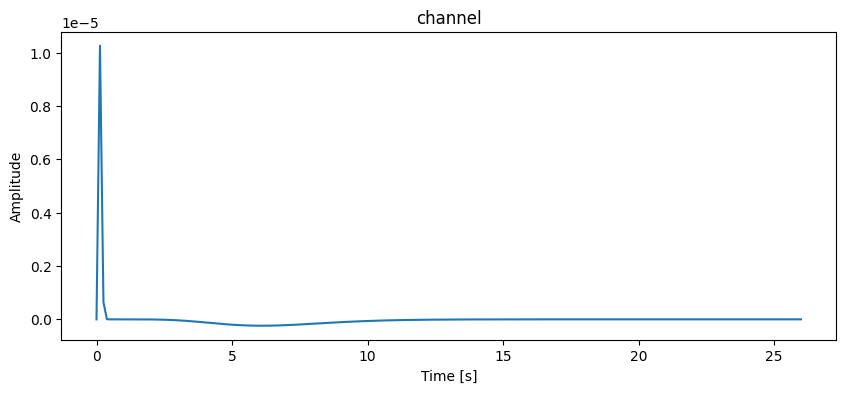

In [377]:
# Actually generating the data
signal_number = 1000000
signal_length = len(time_signal)
initial_parameters = [3, 5, 2, 1]
p_mean, p_var = 0, 1


# Currently we'll be working on the first channel only, for simplicity's sake
gamma_params = models.get_basic_gamma_params(avg_haemo_func_tapping.data[0], time_signal, initial_parameters)
print("this is the length of gamma params", len(gamma_params))
clean_data = models.generate_gamma_set(time_signal, gamma_params, signal_number, magnitude_correction=1.2*1e-6, mean=p_mean, var=p_var)
print("this is the length of clean data", len(clean_data))
# null_data = np.zeros((signal_number - (signal_number//5),) + np.shape(clean_data)[1:])
# print("This is the shape of the null_data", np.shape(null_data))

# clean_data = np.concatenate((clean_data, null_data))
print(np.shape(clean_data), "is clean's len")
print("concatenated successfully")
print(np.shape(clean_data))
displays.plot_pChannel(clean_data[0], time_signal)

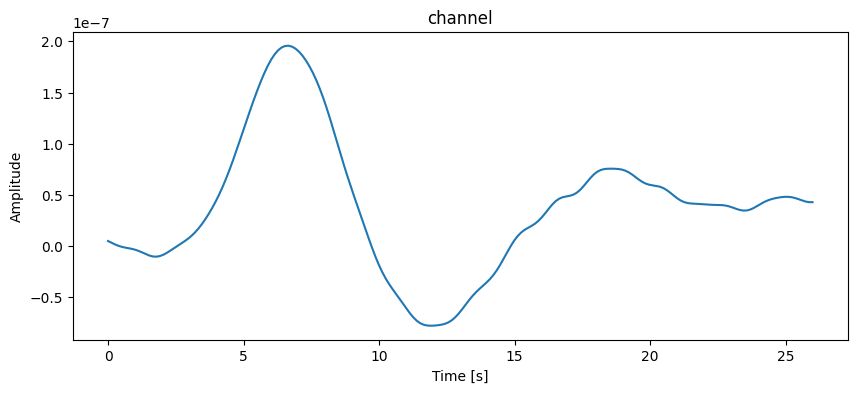

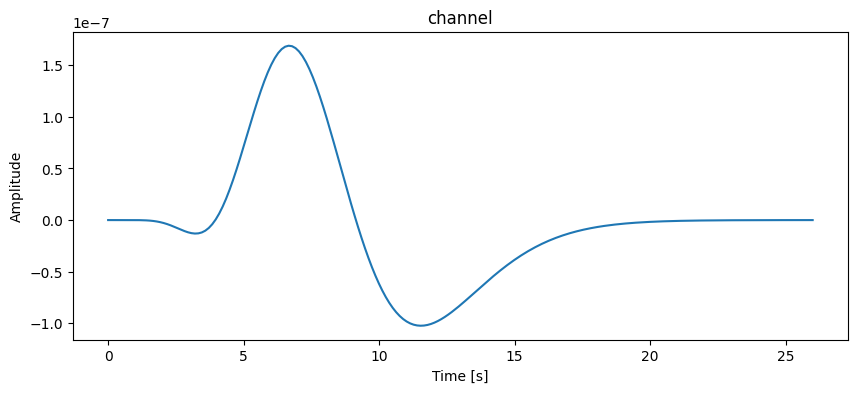

In [483]:
displays.plot_pChannel(avg_haemo_func_tapping.data[2], time_signal)
gamma_test_params = models.get_basic_gamma_params(avg_haemo_func_tapping.data[2], time_signal, initial_parameters)

displays.plot_pChannel(np.array([models.bC_hrf(t_p, gamma_test_params[0], gamma_test_params[1], gamma_test_params[2], gamma_test_params[3]) for t_p in time_signal]), time_signal)


In [435]:
print(np.shape(time_signal))
print(np.shape(clean_data))

(204,)
(1000000, 204)


In [378]:
baseline_data = models.generate_regressive_noise_set(signal_number, signal_length)

baseline_data = models.generate_white_noise_set(signal_number, len(clean_data[0]), 0.1, 0.1, np.mean(clean_data)/2, np.std(clean_data)/5, 7.81)
print("this is the length of noise data", len(baseline_data))
np.random.shuffle(clean_data)
# print("This is the length of the base_line data", len(baseline_data))
overlayed_data = np.add(clean_data, baseline_data)
print("we done...")

this is the length of noise data 1000000
we done...


In [379]:
# Preprocesssing the data
z_mean, z_std = np.mean(np.concatenate((clean_data, overlayed_data))), np.std(np.concatenate((clean_data, overlayed_data)))
z_clean = convs.z_curve_normalisation(np.concatenate((clean_data, overlayed_data)))[:signal_number]
z_overlay = convs.z_curve_normalisation(np.concatenate((clean_data, overlayed_data)))[signal_number:]

print(np.shape(z_overlay), np.shape(z_clean), np.shape(baseline_data))
print(np.mean(np.concatenate((clean_data, overlayed_data))))

(1000000, 204) (1000000, 204) (1000000, 204)
6.7887432516708615e-09


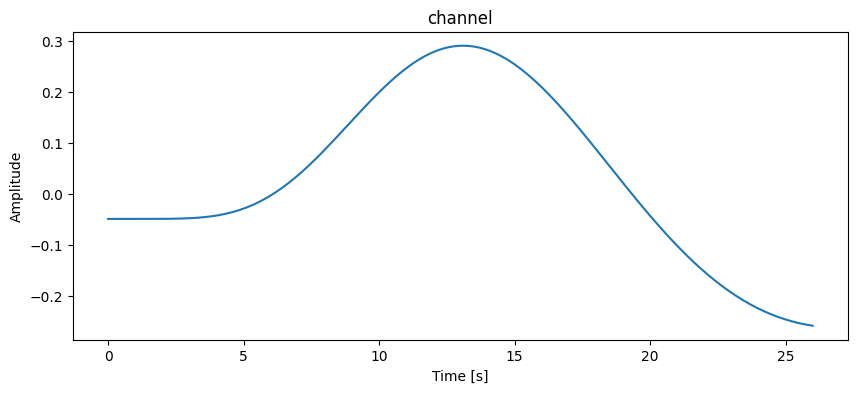

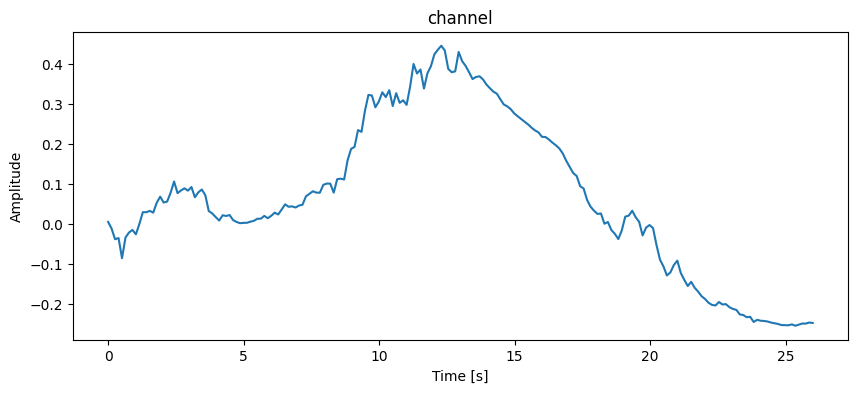

In [478]:
rand_num = random.randint(0, 10000)
displays.plot_pChannel(z_clean[rand_num], time_signal)
displays.plot_pChannel(z_overlay[rand_num], time_signal)



In [350]:
class Amp_Lin_AutoEncoder(nn.Module):
    # This is my linear neural network implementation of an auto-encoder using amplitude points
    def __init__(self, signal_length):
        # Signal length has to be longer than 200
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(signal_length, 168),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(168, 84),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(84, 52),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(52, 24),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(24, 10)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(10, 24),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(24, 52),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(52, 84),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(84, 168),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(168, signal_length)
        )
        
    def forward(self, x):
        code = self.encoder(x)
        decoded = self.decoder(code)
        return decoded    
    
amp_lin_model = Amp_Lin_AutoEncoder(len(z_clean[0]))

In [351]:
# Dataset classes for encoer
basic_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.astype('float32')),
    transforms.ToTensor()
])


# Dataset for training with data as a set of amplitude points
class amp_dataset(Dataset):
    def __init__(self, clean, overlayed, transform):
        assert(len(clean) == len(overlayed))
        self.clean = clean
        self.overlayed = overlayed
        self.transform = transform
    
    def __len__(self):
        return len(self.overlayed)
    
    def __getitem__(self, idx):
        if self.transform is None:
            self.transform = lambda x: x
            
        clean = self.transform(self.clean[idx].reshape(1, -1))            
        noisy = self.transform(self.overlayed[idx].reshape(1, -1))
        
        return clean, noisy

amp_set = amp_dataset(z_clean, z_overlay, basic_transform)
amp_set_conv = amp_dataset(z_clean, z_overlay, basic_transform)

amp_dataloader = DataLoader(amp_set, batch_size=320, shuffle=True)
amp_conv_dataloader = DataLoader(amp_set_conv, batch_size=320, shuffle=True)


In [359]:
class Amp_Con_AutoEncoder(nn.Module):
    # This is the convolutional neural network implementation of an auto-encoder using amplitude points (for a single channel)
    def __init__(self):
        # This is a 1d convolutional neural network implementation, it would be better to consider multiple channels overall
        # but we're not at that point right now.
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=8, kernel_size=9, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Conv1d(in_channels=8, out_channels=16, kernel_size=9, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=9, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=9, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=9, stride=2, padding=1),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=128, out_channels=64, kernel_size=9, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.ConvTranspose1d(in_channels=64, out_channels=32, kernel_size=9, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.ConvTranspose1d(in_channels=32, out_channels=16, kernel_size=9, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.ConvTranspose1d(in_channels=16, out_channels=8, kernel_size=9, stride=2, padding=2),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.ConvTranspose1d(in_channels=8, out_channels=1, kernel_size=9, stride=2, padding=3, output_padding=1)
        )
        
    def forward(self, x):
        x = x.squeeze(1) # We have an extra singleton dimensions
        code = self.encoder(x)
        decoded = self.decoder(code)
        return decoded
    
amp_con_model = Amp_Con_AutoEncoder()

In [353]:
def initialise_weights(model):
    if isinstance(model, nn.Linear):
        # Supposedly a good idea for linear models...
        nn.init.xavier_uniform_(model.weight)
        nn.init.zeros_(model.bias)

In [380]:
# Amplitude training's section for linear model
amp_lin_model.apply(initialise_weights)
amp_loss_function = nn.MSELoss() # Amplitude doesn't struggle with issues of magnitude like frequency representation
amp_optimiser = optim.Adam(amp_lin_model.parameters(), lr=1e-3)
amp_epochs = 1000

for epoch in range(amp_epochs):
    for (clean, dirty) in amp_conv_dataloader:
        reconstructed = amp_lin_model(dirty)
        loss = amp_loss_function(reconstructed, clean)
        
        amp_optimiser.zero_grad()
        loss.backward()
        amp_optimiser.step()
    
    print(f"In epoch {epoch+1} of {amp_epochs}, there was a loss of {loss.item():.3} ")


In epoch 1 of 1000, there was a loss of 0.0162 
In epoch 2 of 1000, there was a loss of 0.00744 
In epoch 3 of 1000, there was a loss of 0.00891 
In epoch 4 of 1000, there was a loss of 0.00369 
In epoch 5 of 1000, there was a loss of 0.0055 
In epoch 6 of 1000, there was a loss of 0.00227 
In epoch 7 of 1000, there was a loss of 0.00259 
In epoch 8 of 1000, there was a loss of 0.0025 
In epoch 9 of 1000, there was a loss of 0.00207 
In epoch 10 of 1000, there was a loss of 0.00203 
In epoch 11 of 1000, there was a loss of 0.0016 
In epoch 12 of 1000, there was a loss of 0.00379 
In epoch 13 of 1000, there was a loss of 0.00239 
In epoch 14 of 1000, there was a loss of 0.00212 
In epoch 15 of 1000, there was a loss of 0.00173 
In epoch 16 of 1000, there was a loss of 0.00183 
In epoch 17 of 1000, there was a loss of 0.00151 
In epoch 18 of 1000, there was a loss of 0.00243 
In epoch 19 of 1000, there was a loss of 0.00899 
In epoch 20 of 1000, there was a loss of 0.00291 
In epoch 21 o

In epoch 163 of 1000, there was a loss of 0.000827 
In epoch 164 of 1000, there was a loss of 0.000678 
In epoch 165 of 1000, there was a loss of 0.00086 
In epoch 166 of 1000, there was a loss of 0.000742 
In epoch 167 of 1000, there was a loss of 0.000571 
In epoch 168 of 1000, there was a loss of 0.000514 
In epoch 169 of 1000, there was a loss of 0.000687 
In epoch 170 of 1000, there was a loss of 0.000585 
In epoch 171 of 1000, there was a loss of 0.000775 
In epoch 172 of 1000, there was a loss of 0.000818 
In epoch 173 of 1000, there was a loss of 0.000697 
In epoch 174 of 1000, there was a loss of 0.00659 
In epoch 175 of 1000, there was a loss of 0.000572 
In epoch 176 of 1000, there was a loss of 0.00143 
In epoch 177 of 1000, there was a loss of 0.000735 
In epoch 178 of 1000, there was a loss of 0.000518 
In epoch 179 of 1000, there was a loss of 0.000645 
In epoch 180 of 1000, there was a loss of 0.000796 
In epoch 181 of 1000, there was a loss of 0.000677 
In epoch 182 of

In epoch 322 of 1000, there was a loss of 0.00192 
In epoch 323 of 1000, there was a loss of 0.000619 
In epoch 324 of 1000, there was a loss of 0.000608 
In epoch 325 of 1000, there was a loss of 0.000564 
In epoch 326 of 1000, there was a loss of 0.000439 
In epoch 327 of 1000, there was a loss of 0.000379 
In epoch 328 of 1000, there was a loss of 0.000587 
In epoch 329 of 1000, there was a loss of 0.000526 
In epoch 330 of 1000, there was a loss of 0.00045 
In epoch 331 of 1000, there was a loss of 0.000592 
In epoch 332 of 1000, there was a loss of 0.000487 
In epoch 333 of 1000, there was a loss of 0.000438 
In epoch 334 of 1000, there was a loss of 0.000563 
In epoch 335 of 1000, there was a loss of 0.000492 
In epoch 336 of 1000, there was a loss of 0.000576 
In epoch 337 of 1000, there was a loss of 0.000597 
In epoch 338 of 1000, there was a loss of 0.000801 
In epoch 339 of 1000, there was a loss of 0.000598 
In epoch 340 of 1000, there was a loss of 0.000502 
In epoch 341 o

In epoch 481 of 1000, there was a loss of 0.00041 
In epoch 482 of 1000, there was a loss of 0.000554 
In epoch 483 of 1000, there was a loss of 0.000655 
In epoch 484 of 1000, there was a loss of 0.000535 
In epoch 485 of 1000, there was a loss of 0.000506 
In epoch 486 of 1000, there was a loss of 0.00109 
In epoch 487 of 1000, there was a loss of 0.000461 
In epoch 488 of 1000, there was a loss of 0.00069 
In epoch 489 of 1000, there was a loss of 0.000676 
In epoch 490 of 1000, there was a loss of 0.000457 
In epoch 491 of 1000, there was a loss of 0.000452 
In epoch 492 of 1000, there was a loss of 0.000492 
In epoch 493 of 1000, there was a loss of 0.00045 
In epoch 494 of 1000, there was a loss of 0.000339 
In epoch 495 of 1000, there was a loss of 0.000735 
In epoch 496 of 1000, there was a loss of 0.000485 
In epoch 497 of 1000, there was a loss of 0.000421 
In epoch 498 of 1000, there was a loss of 0.000449 
In epoch 499 of 1000, there was a loss of 0.000687 
In epoch 500 of 

In epoch 639 of 1000, there was a loss of 0.00037 
In epoch 640 of 1000, there was a loss of 0.000458 
In epoch 641 of 1000, there was a loss of 0.000379 
In epoch 642 of 1000, there was a loss of 0.000451 
In epoch 643 of 1000, there was a loss of 0.000783 
In epoch 644 of 1000, there was a loss of 0.000848 
In epoch 645 of 1000, there was a loss of 0.000866 
In epoch 646 of 1000, there was a loss of 0.00102 
In epoch 647 of 1000, there was a loss of 0.000721 
In epoch 648 of 1000, there was a loss of 0.000398 
In epoch 649 of 1000, there was a loss of 0.000481 
In epoch 650 of 1000, there was a loss of 0.000396 
In epoch 651 of 1000, there was a loss of 0.000418 
In epoch 652 of 1000, there was a loss of 0.000495 
In epoch 653 of 1000, there was a loss of 0.000402 
In epoch 654 of 1000, there was a loss of 0.000392 
In epoch 655 of 1000, there was a loss of 0.00042 
In epoch 656 of 1000, there was a loss of 0.000456 
In epoch 657 of 1000, there was a loss of 0.000448 
In epoch 658 of

In epoch 797 of 1000, there was a loss of 0.00405 
In epoch 798 of 1000, there was a loss of 0.00058 
In epoch 799 of 1000, there was a loss of 0.000311 
In epoch 800 of 1000, there was a loss of 0.000396 
In epoch 801 of 1000, there was a loss of 0.000322 
In epoch 802 of 1000, there was a loss of 0.000421 
In epoch 803 of 1000, there was a loss of 0.000384 
In epoch 804 of 1000, there was a loss of 0.000379 
In epoch 805 of 1000, there was a loss of 0.000481 
In epoch 806 of 1000, there was a loss of 0.000998 
In epoch 807 of 1000, there was a loss of 0.000449 
In epoch 808 of 1000, there was a loss of 0.000486 
In epoch 809 of 1000, there was a loss of 0.000765 
In epoch 810 of 1000, there was a loss of 0.000737 
In epoch 811 of 1000, there was a loss of 0.000645 
In epoch 812 of 1000, there was a loss of 0.000478 
In epoch 813 of 1000, there was a loss of 0.000378 
In epoch 814 of 1000, there was a loss of 0.000454 
In epoch 815 of 1000, there was a loss of 0.000504 
In epoch 816 o

In epoch 956 of 1000, there was a loss of 0.00043 
In epoch 957 of 1000, there was a loss of 0.000512 
In epoch 958 of 1000, there was a loss of 0.000762 
In epoch 959 of 1000, there was a loss of 0.000378 
In epoch 960 of 1000, there was a loss of 0.000366 
In epoch 961 of 1000, there was a loss of 0.00035 
In epoch 962 of 1000, there was a loss of 0.000341 
In epoch 963 of 1000, there was a loss of 0.000521 
In epoch 964 of 1000, there was a loss of 0.000346 
In epoch 965 of 1000, there was a loss of 0.000398 
In epoch 966 of 1000, there was a loss of 0.000654 
In epoch 967 of 1000, there was a loss of 0.000675 
In epoch 968 of 1000, there was a loss of 0.00229 
In epoch 969 of 1000, there was a loss of 0.000326 
In epoch 970 of 1000, there was a loss of 0.000353 
In epoch 971 of 1000, there was a loss of 0.000378 
In epoch 972 of 1000, there was a loss of 0.000867 
In epoch 973 of 1000, there was a loss of 0.000467 
In epoch 974 of 1000, there was a loss of 0.000607 
In epoch 975 of

In [376]:
# amplitude training's section for convolutional model 
# amp_con_model.apply(initialise_weights)
amp_conv_loss_function = nn.MSELoss()
amp_conv_optimiser = optim.Adam(amp_con_model.parameters(), lr=1e-3)
amp_conv_epochs = 50

for epoch in range(amp_conv_epochs):
    for (clean_conv, dirty_conv) in amp_conv_dataloader: # Same dataset used as for linear version
        conv_reconstructed = amp_con_model(dirty_conv)
        conv_loss = amp_conv_loss_function(conv_reconstructed, clean_conv.squeeze(1))
        amp_conv_optimiser.zero_grad()
        conv_loss.backward()
        amp_conv_optimiser.step()
    print(f"In epoch {epoch+1} of {amp_conv_epochs}, there was a loss of {conv_loss.item():.4} ")


In epoch 1 of 50, there was a loss of 0.002464 
In epoch 2 of 50, there was a loss of 0.004887 
In epoch 3 of 50, there was a loss of 0.002233 
In epoch 4 of 50, there was a loss of 0.001755 
In epoch 5 of 50, there was a loss of 0.002071 
In epoch 6 of 50, there was a loss of 0.002918 
In epoch 7 of 50, there was a loss of 0.00112 
In epoch 8 of 50, there was a loss of 0.00125 
In epoch 9 of 50, there was a loss of 0.001831 
In epoch 10 of 50, there was a loss of 0.001449 
In epoch 11 of 50, there was a loss of 0.001359 
In epoch 12 of 50, there was a loss of 0.002322 
In epoch 13 of 50, there was a loss of 0.001009 
In epoch 14 of 50, there was a loss of 0.001613 
In epoch 15 of 50, there was a loss of 0.001595 
In epoch 16 of 50, there was a loss of 0.001276 
In epoch 17 of 50, there was a loss of 0.001084 
In epoch 18 of 50, there was a loss of 0.002068 
In epoch 19 of 50, there was a loss of 0.00066 
In epoch 20 of 50, there was a loss of 0.001145 
In epoch 21 of 50, there was a l

In [ ]:
# Wavelet representation section

# clean_data, overlay_data, time_signal is the data that we're working with









In [381]:
print(np.shape(z_clean))

(1000000, 204)


23793


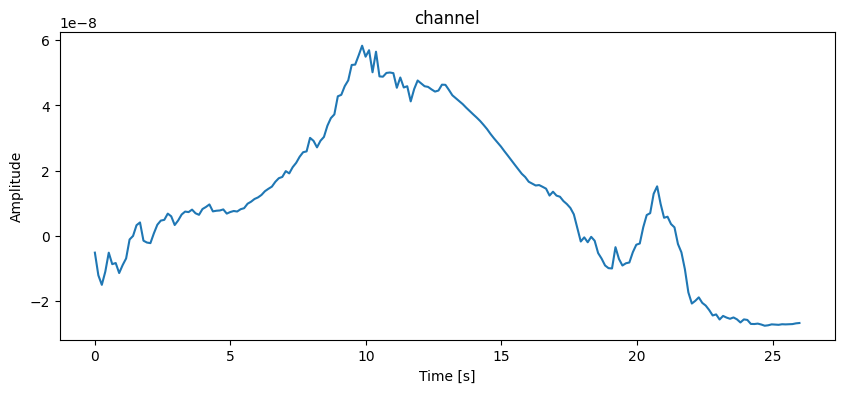

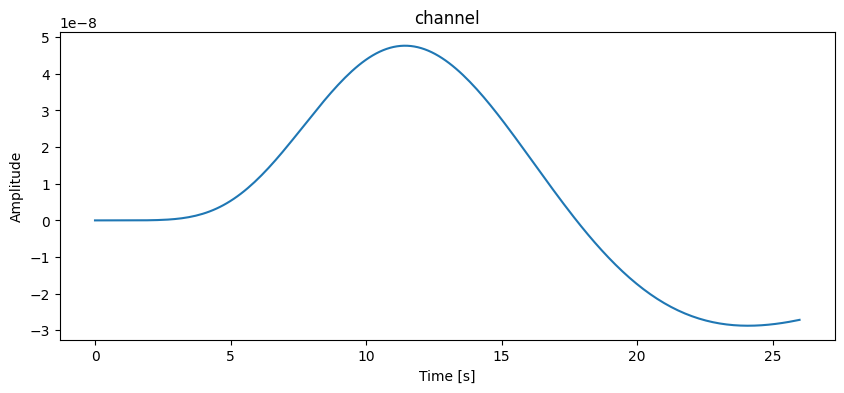

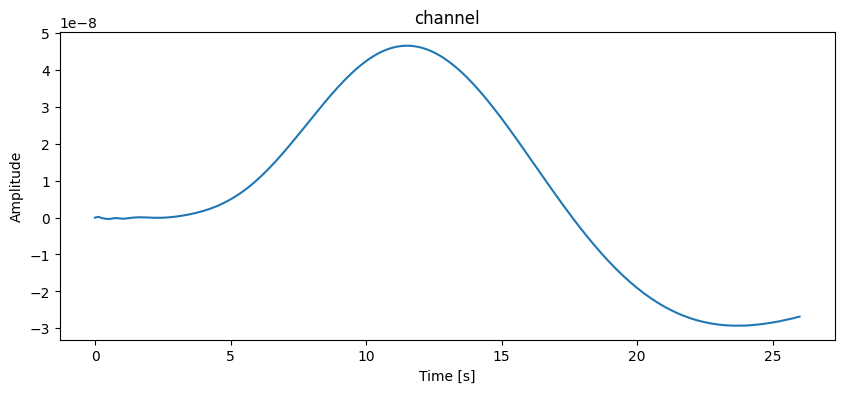

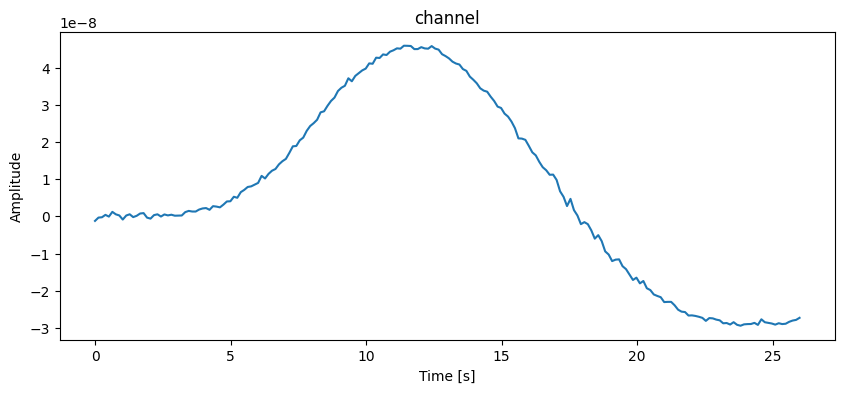

In [484]:
amp_lin_model.eval()
amp_con_model.eval()

random_number = random.randint(0, len(z_clean))
with torch.no_grad():
    input_signal = torch.tensor(z_overlay[random_number], dtype=torch.float32).view(1, -1)
    input_signal_conv = torch.tensor(z_overlay[random_number], dtype=torch.float32).view(1, -1)

    reconstructed_lin_signal = amp_lin_model(input_signal).numpy().flatten()
    reconstructed_conv_signal = amp_con_model(input_signal_conv).numpy().flatten()

print(random_number)
displays.plot_pChannel(convs.inv_z_curve_normalisation(input_signal[0], z_mean, z_std), time_signal)
displays.plot_pChannel(convs.inv_z_curve_normalisation(z_clean[random_number], z_mean, z_std), time_signal)
displays.plot_pChannel(convs.inv_z_curve_normalisation(reconstructed_lin_signal, z_mean, z_std), time_signal)
displays.plot_pChannel(convs.inv_z_curve_normalisation(reconstructed_conv_signal, z_mean, z_std), time_signal)


(204,)
78


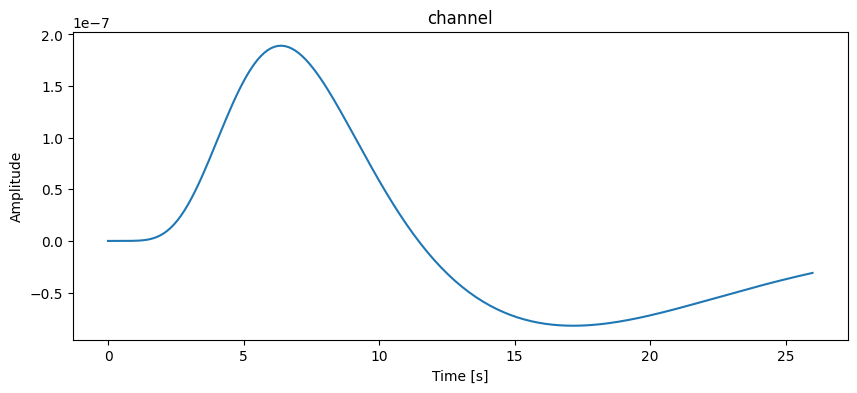

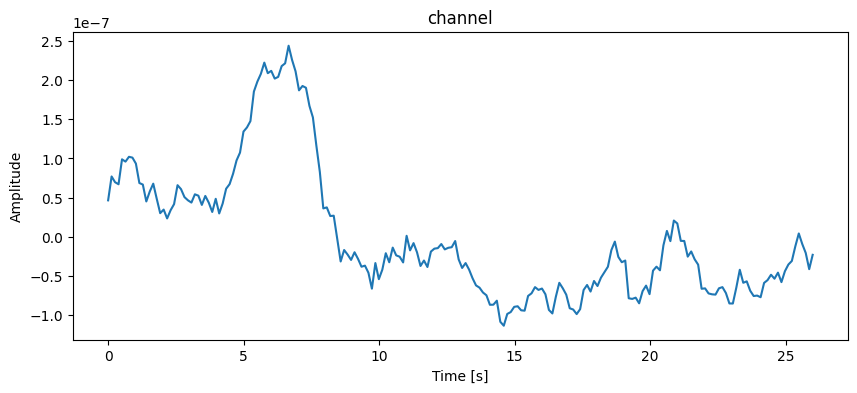

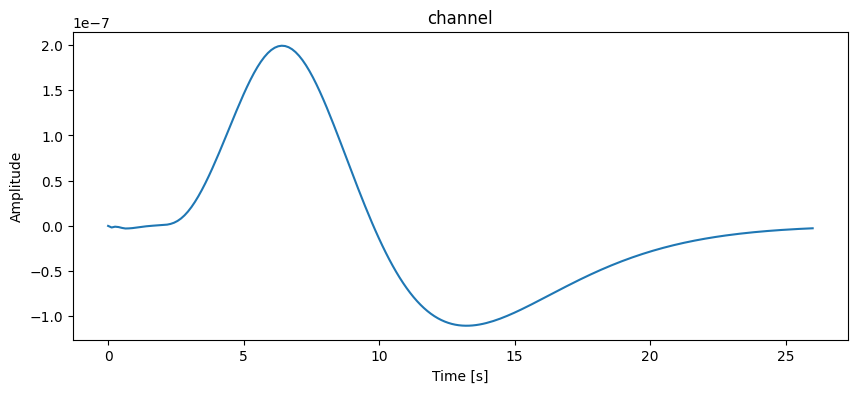

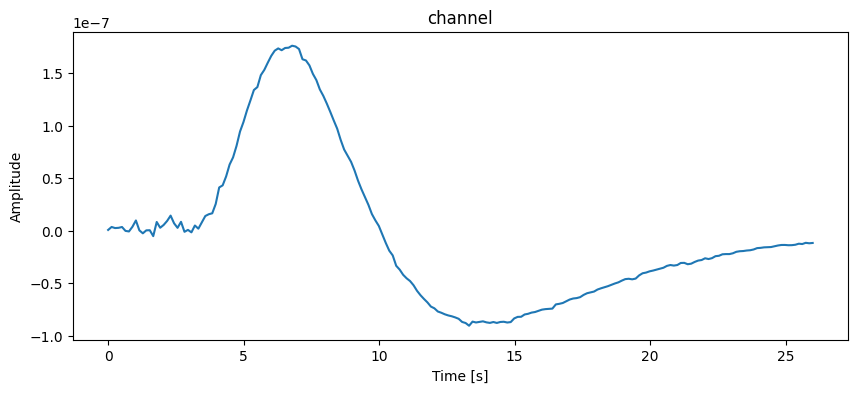

In [492]:
test_num = 100

test_clean = models.generate_gamma_set(time_signal, gamma_params, test_num, magnitude_correction=1.2*1e-6, mean=p_mean, var=p_var)
test_baseline = models.generate_regressive_noise_set(test_num, signal_length)
np.random.shuffle(test_clean)
test_overlay = np.add(test_clean, test_baseline)

amp_lin_model.eval()
amp_con_model.eval()

random_number = random.randint(0, len(test_clean))
with torch.no_grad():
    input_signal = torch.tensor((test_overlay[random_number]-z_mean)/z_std, dtype=torch.float32).view(1, -1)
    input_signal_conv = torch.tensor((test_overlay[random_number]-z_mean)/z_std, dtype=torch.float32).view(1, -1)

    reconstructed_lin_signal = amp_lin_model(input_signal).numpy().flatten()
    reconstructed_conv_signal = amp_con_model(input_signal_conv).numpy().flatten()
    
print(random_number)
displays.plot_pChannel(test_clean[random_number], time_signal)
displays.plot_pChannel(convs.inv_z_curve_normalisation(input_signal[0], z_mean, z_std), time_signal)
displays.plot_pChannel(convs.inv_z_curve_normalisation(reconstructed_lin_signal, z_mean, z_std), time_signal)
displays.plot_pChannel(convs.inv_z_curve_normalisation(reconstructed_conv_signal, z_mean, z_std), time_signal)


In [390]:
torch.save({
    'epoch': epoch,
    'model_state_dict': amp_lin_model.state_dict(),
    'optimizer_state_dict': amp_optimiser.state_dict(),
    'loss': loss,
}, 'amp_lin_100k_model.pth')


In [391]:
torch.save({
    'epoch': epoch,
    'model_state_dict': amp_con_model.state_dict(),
    'optimizer_state_dict': amp_conv_optimiser.state_dict(),
    'loss': conv_loss,
}, 'amp_lin_100k_model.pth')


In [ ]:
######

# THIS IS TESTING
# anything below here is eventually going to be deleted, it's purely for visualisation purposes.




######

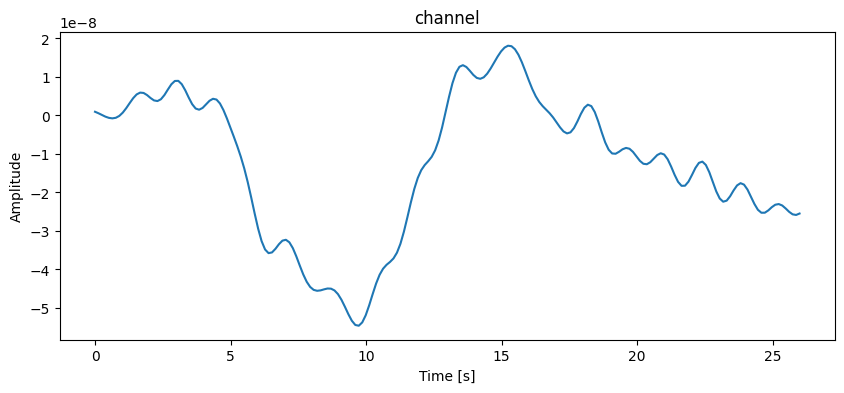

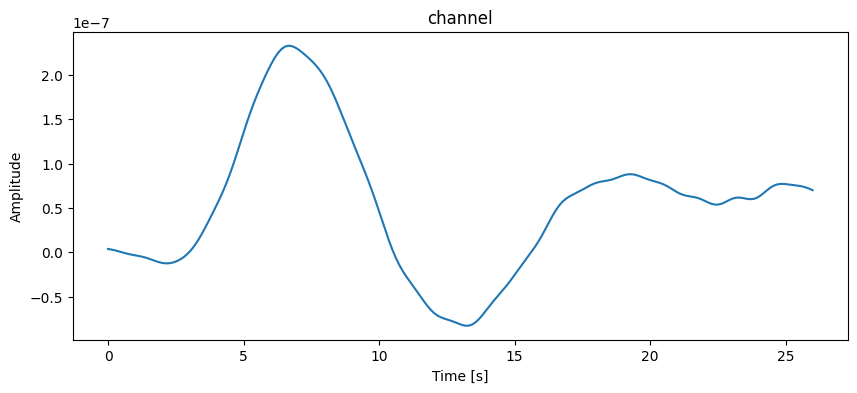

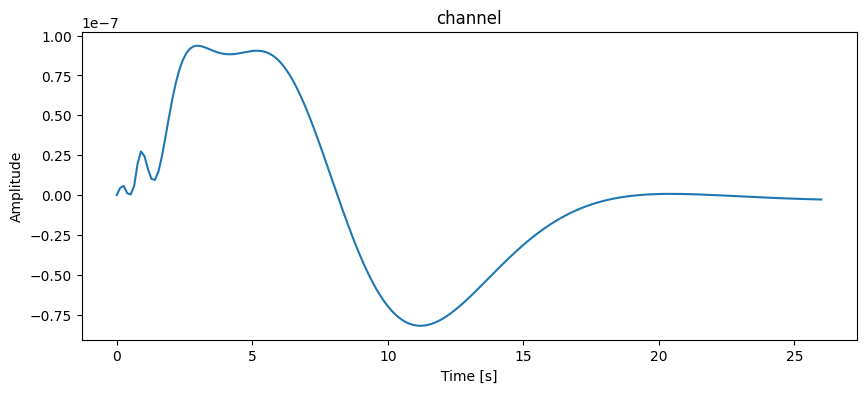

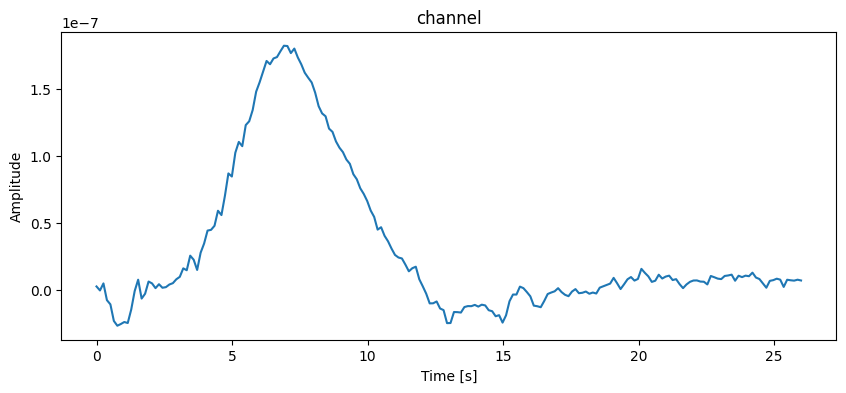

In [422]:
# with torch.no_grad():
#     inp_sig = torch.tensor((avg_haemo_func_tapping.data[4]-z_mean)/z_std, dtype=torch.float32).view(1, -1)

#     avg_lin_recon = amp_lin_model(inp_sig).numpy().flatten()
#     avg_conv_recon = amp_con_model(inp_sig).numpy().flatten()
    
# displays.plot_pChannel(avg_haemo_func_tapping.data[5], time_signal)
# displays.plot_pChannel(convs.inv_z_curve_normalisation(inp_sig[0], z_mean, z_std), time_signal)
# displays.plot_pChannel(convs.inv_z_curve_normalisation(avg_lin_recon, z_mean, z_std), time_signal)
# displays.plot_pChannel(convs.inv_z_curve_normalisation(avg_conv_recon, z_mean, z_std), time_signal)


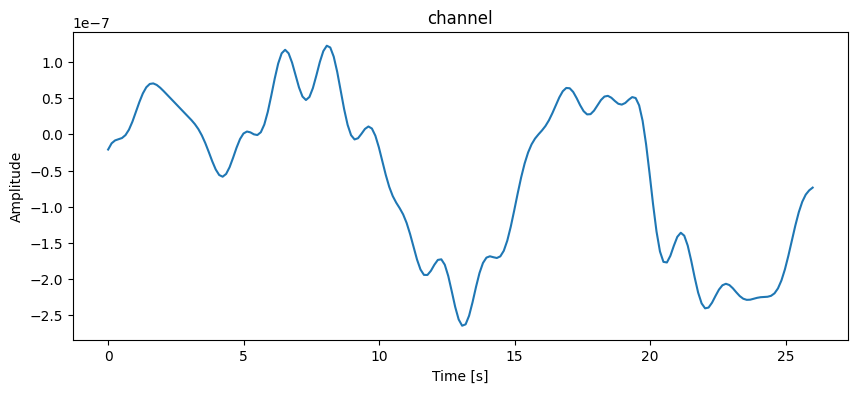

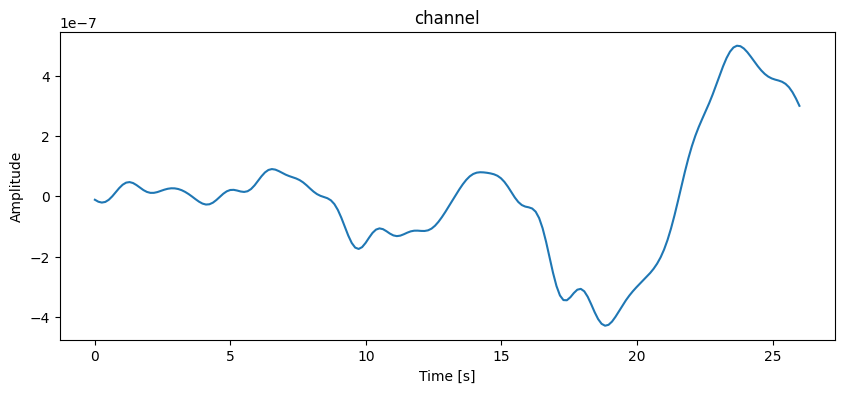

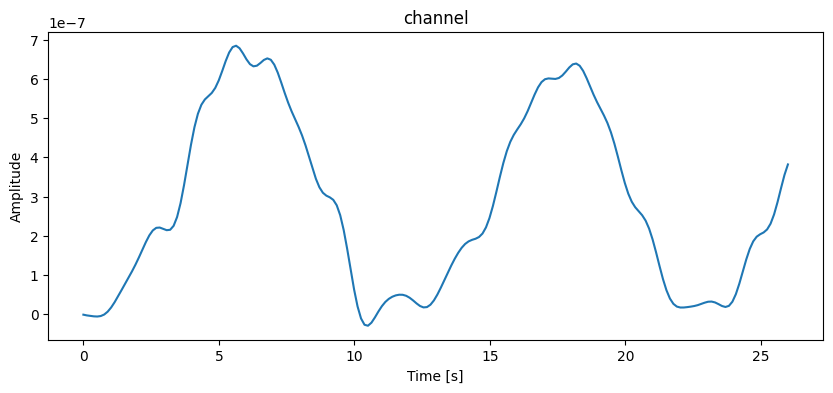

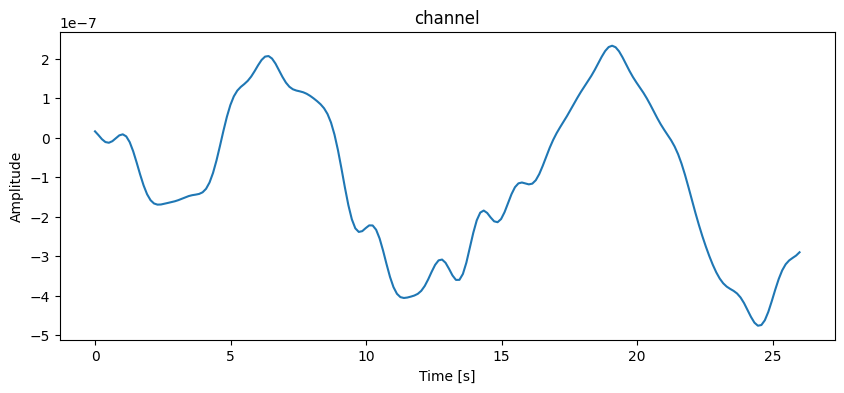

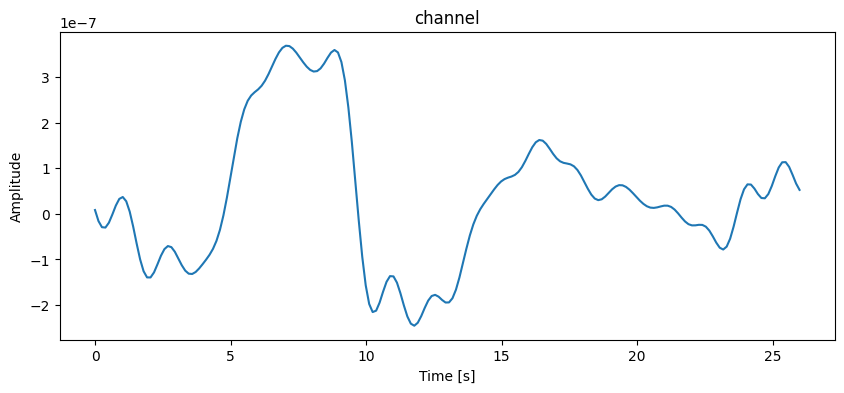

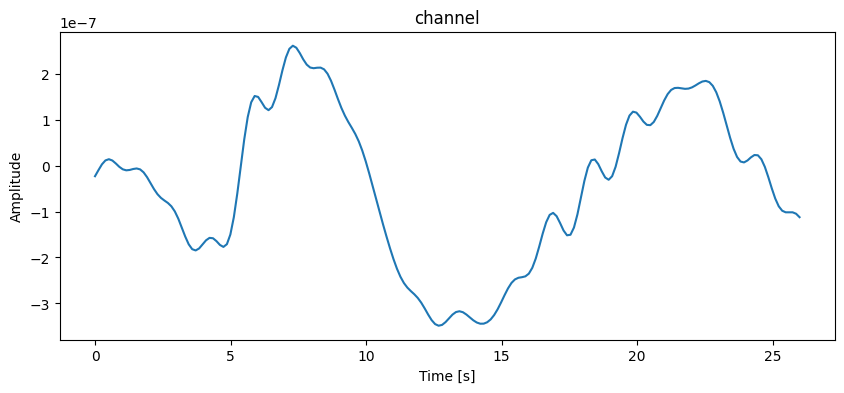

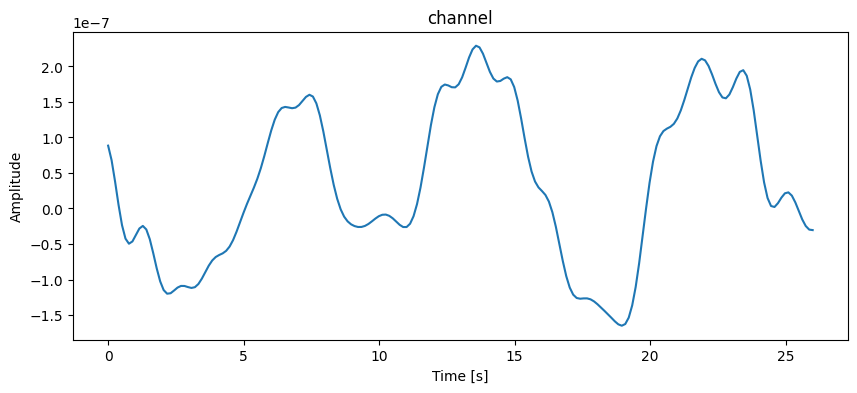

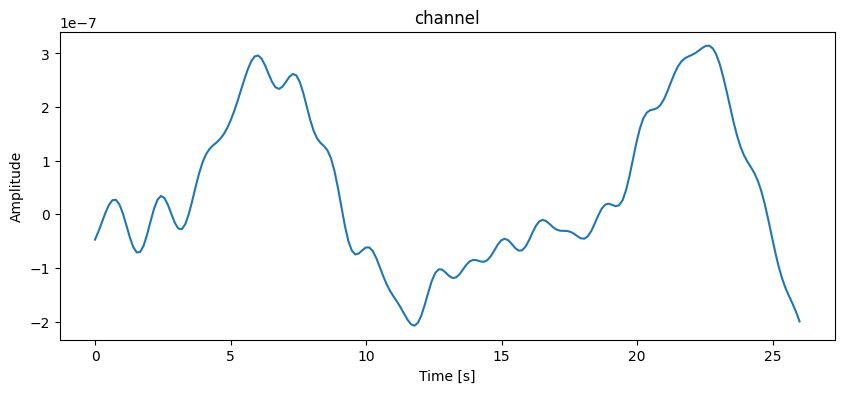

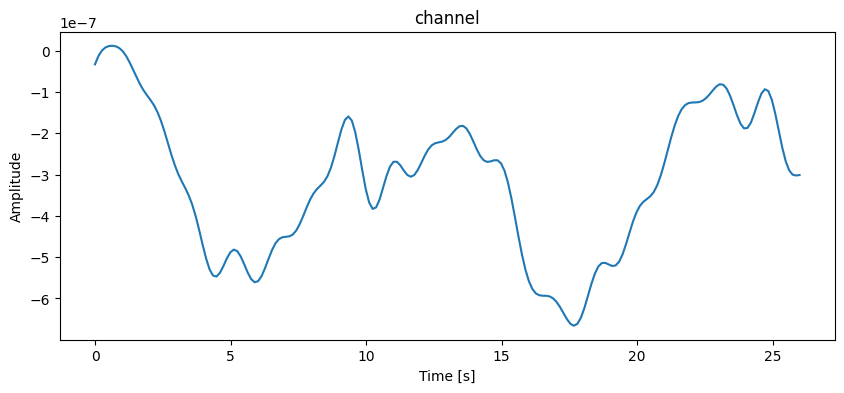

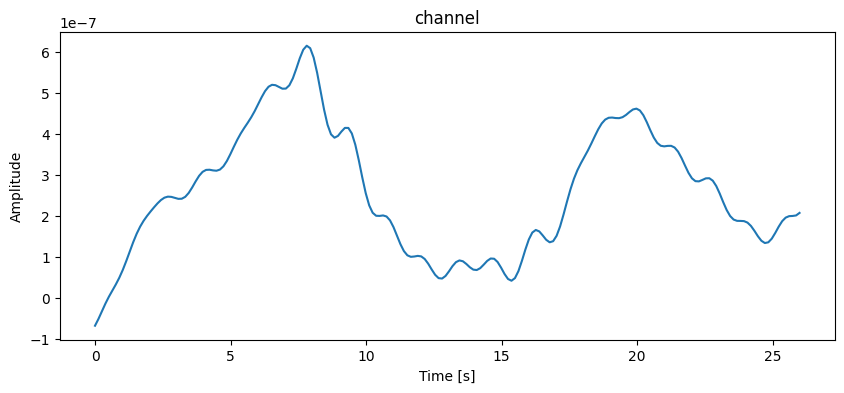

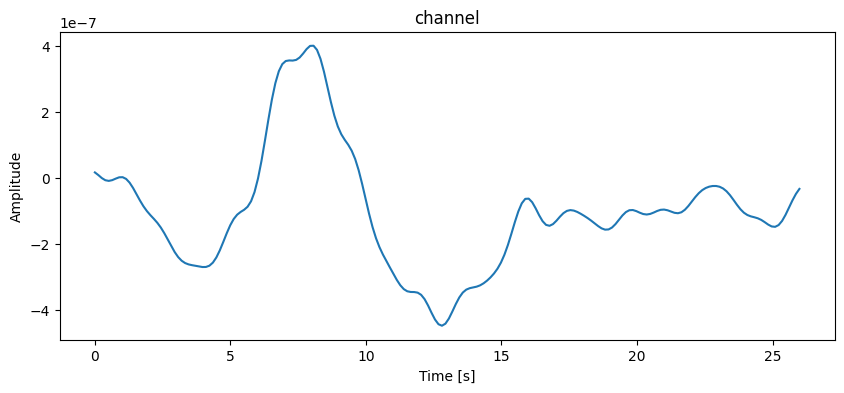

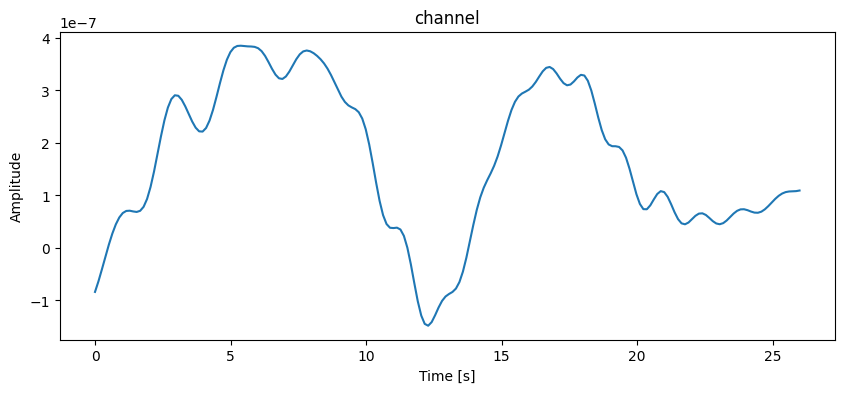

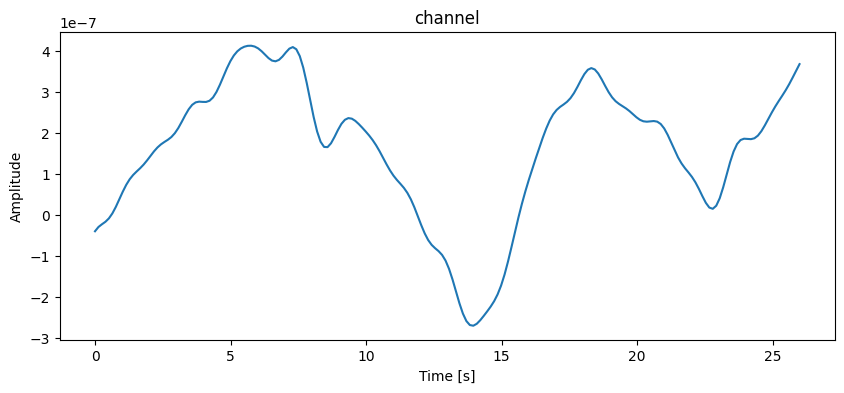

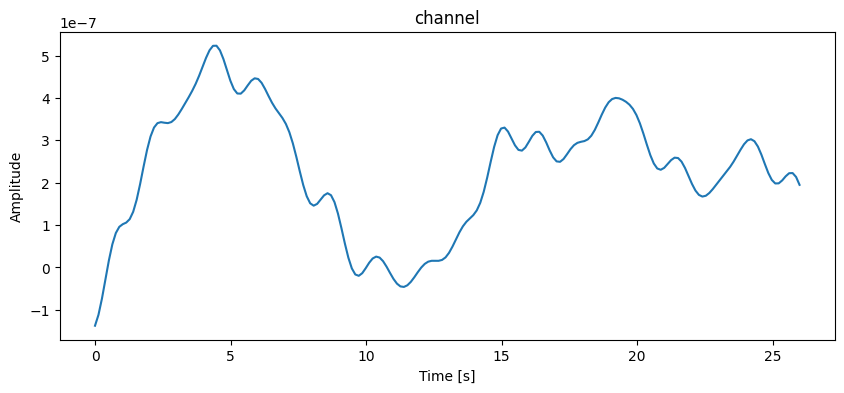

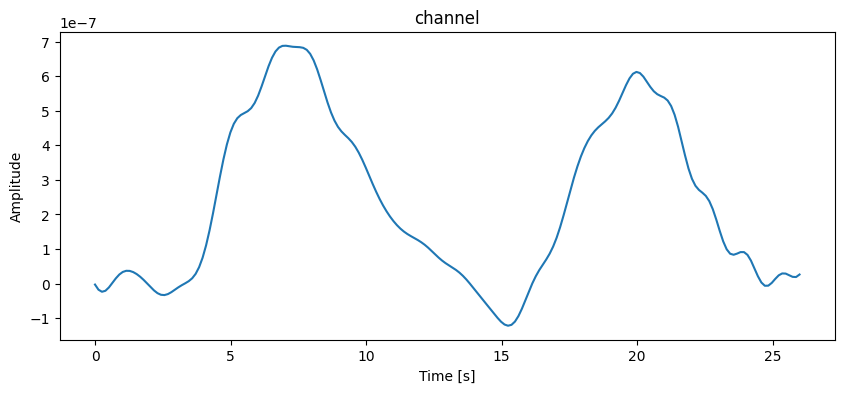

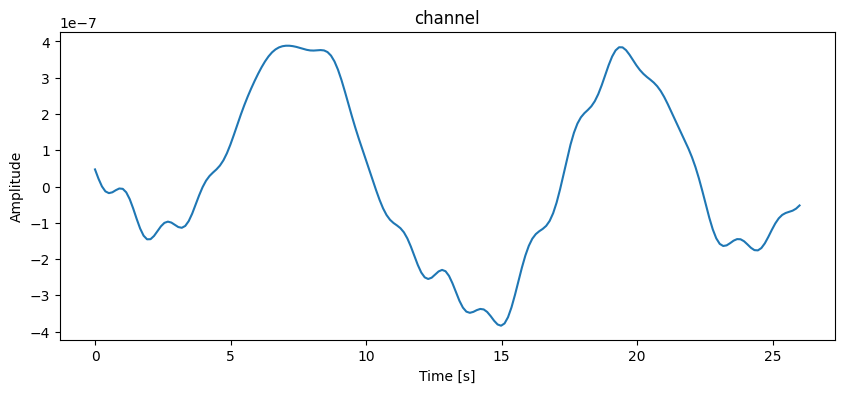

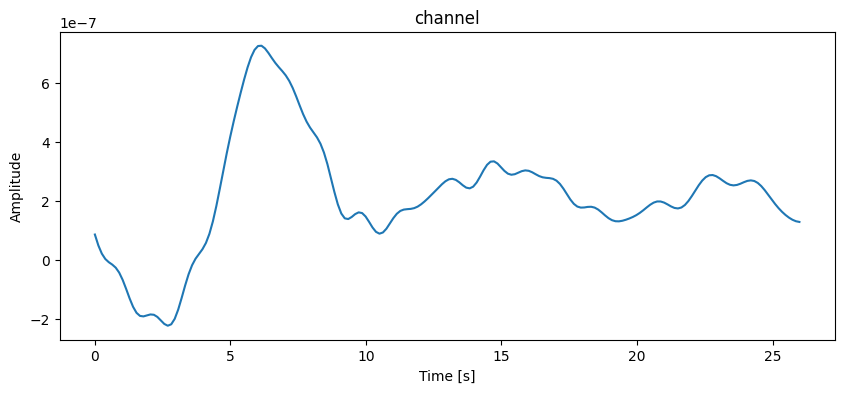

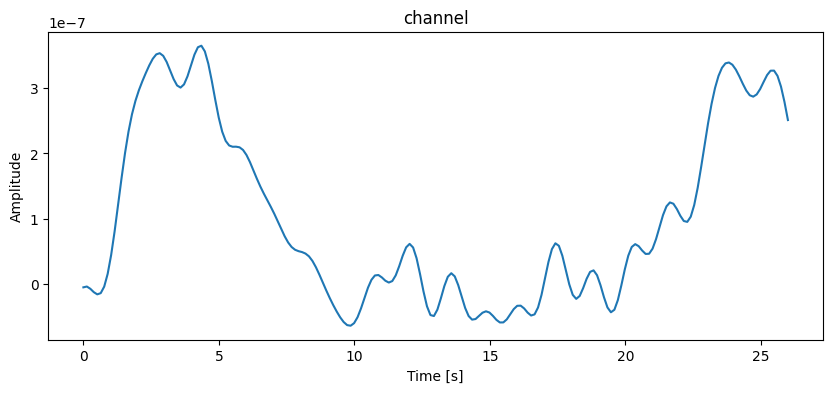

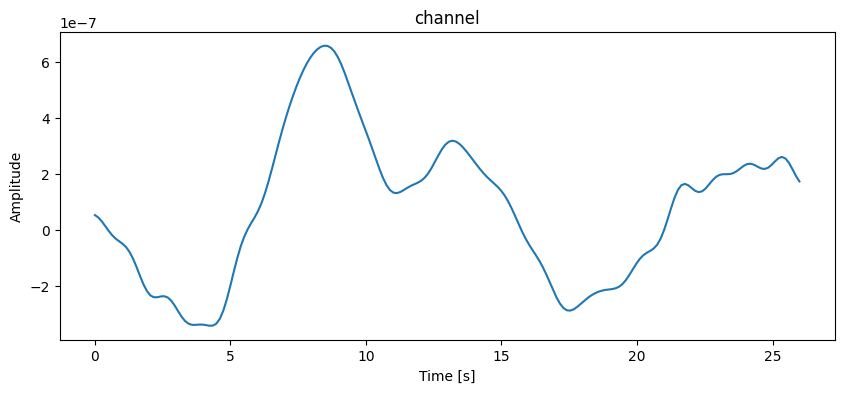

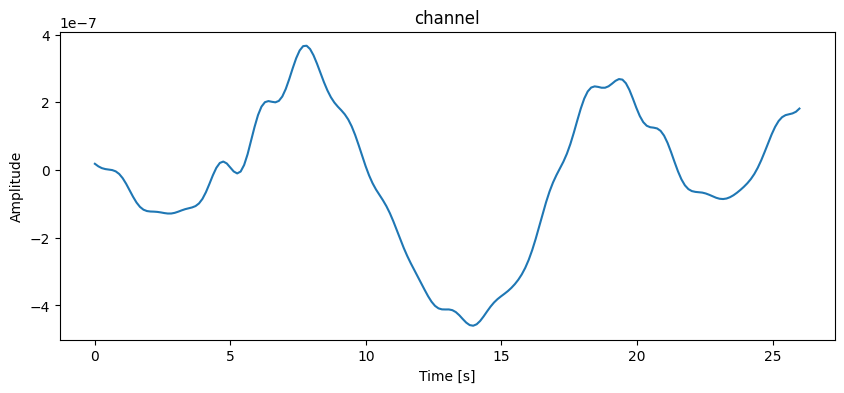

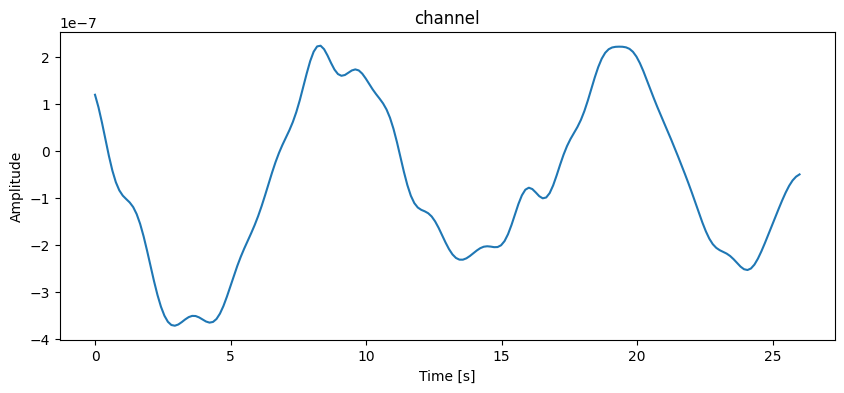

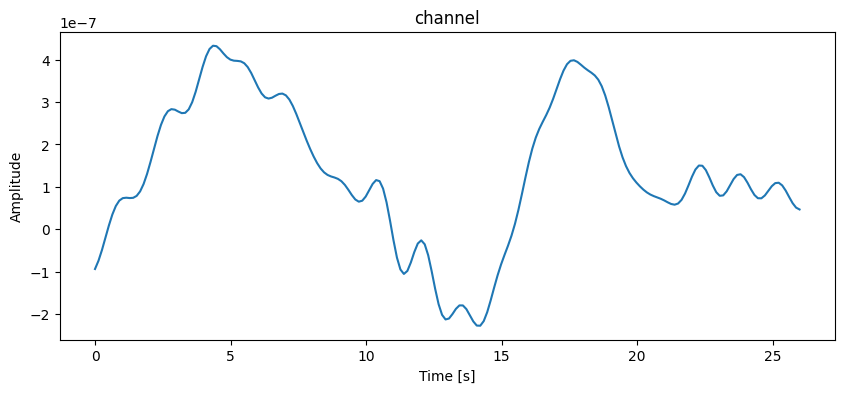

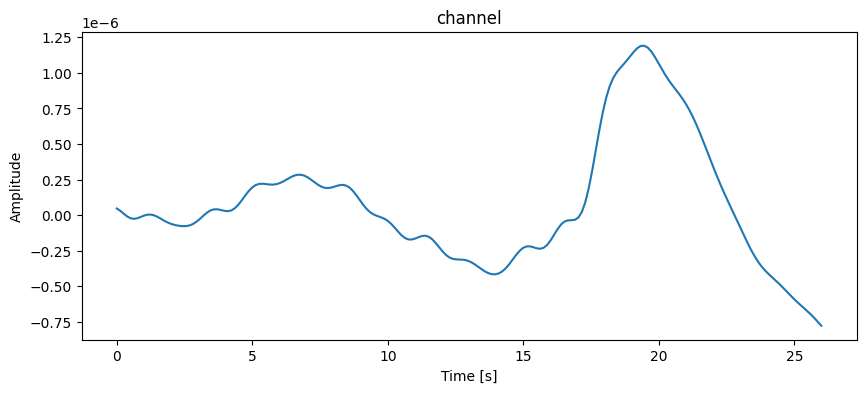

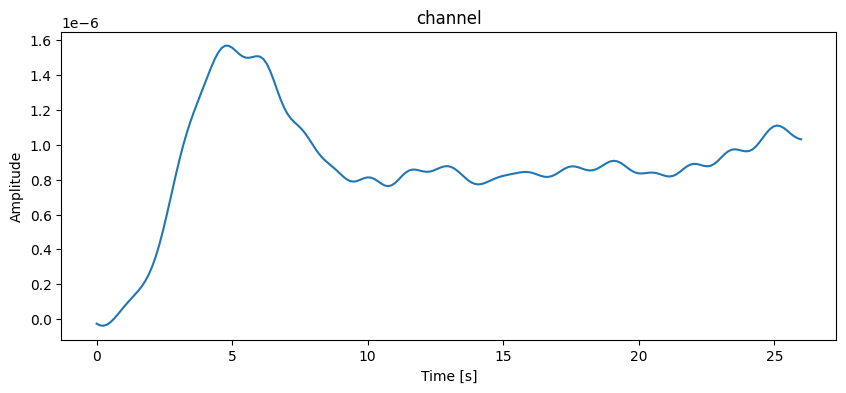

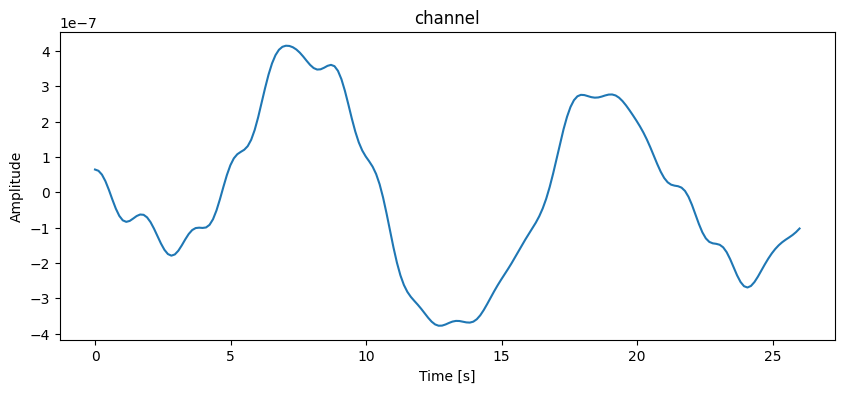

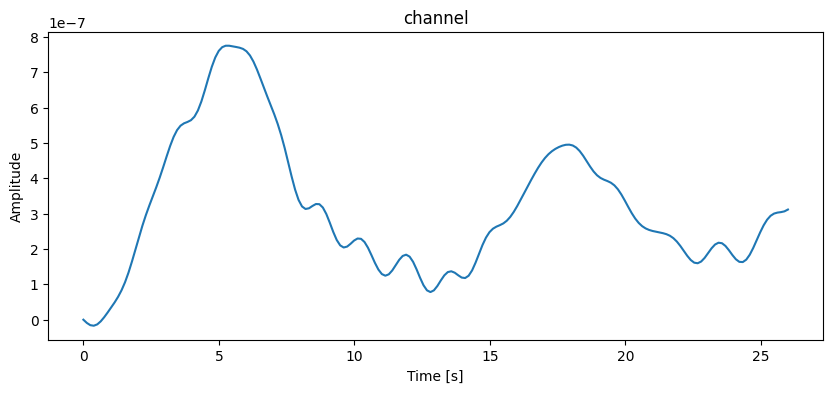

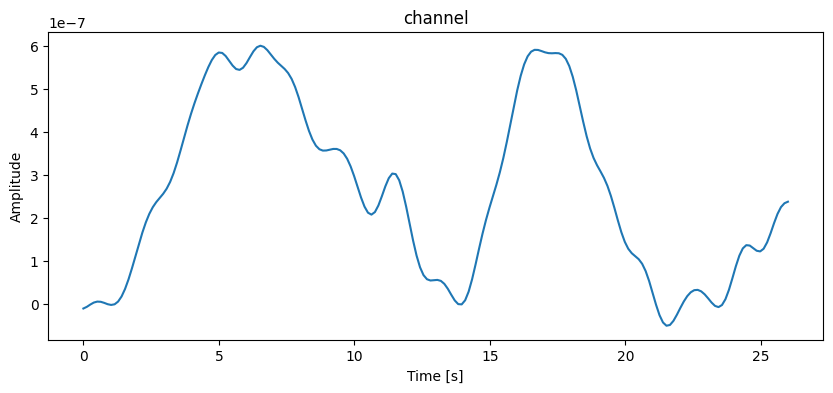

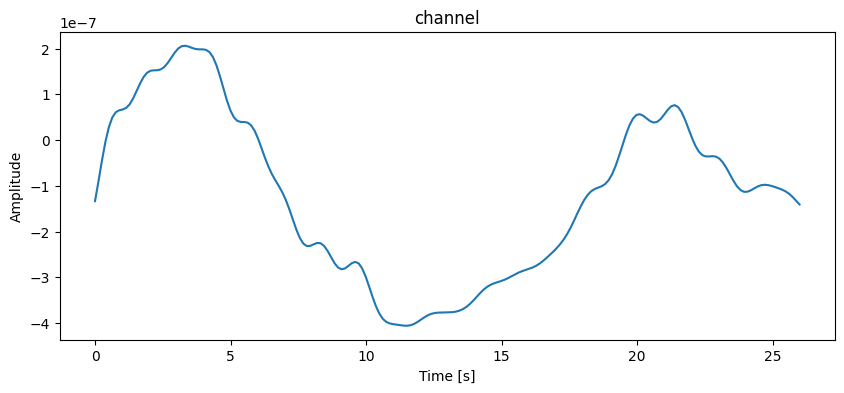

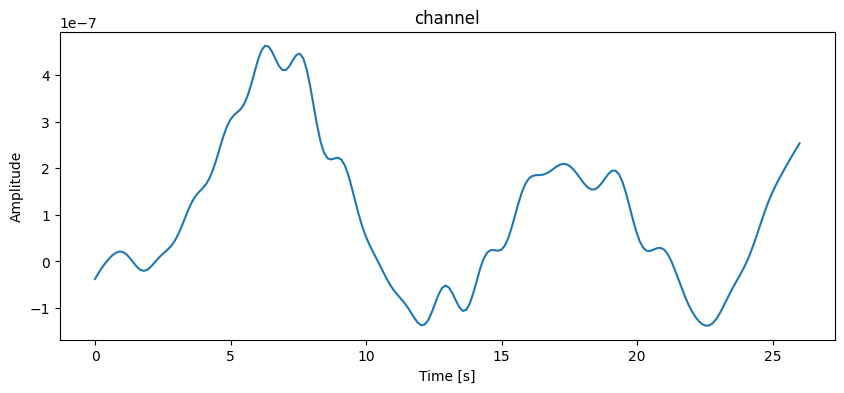

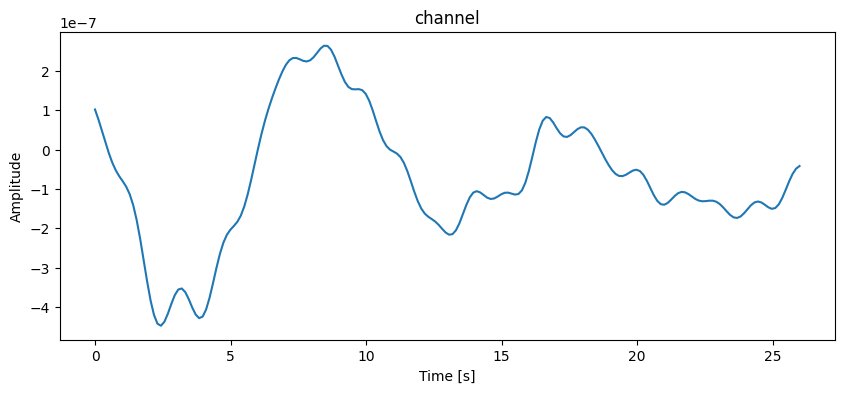

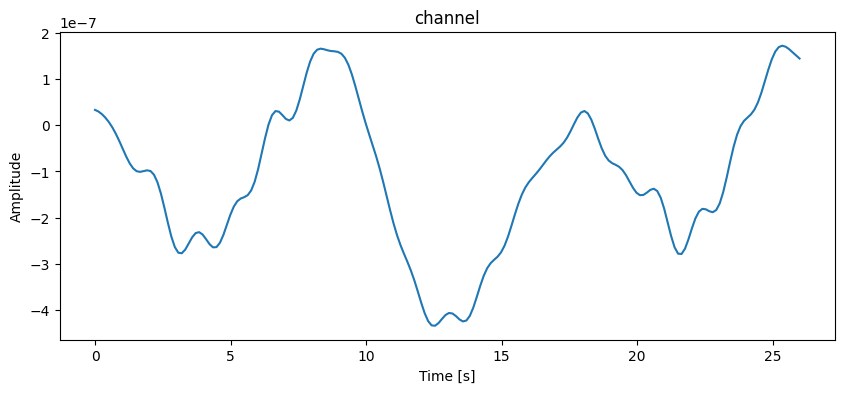

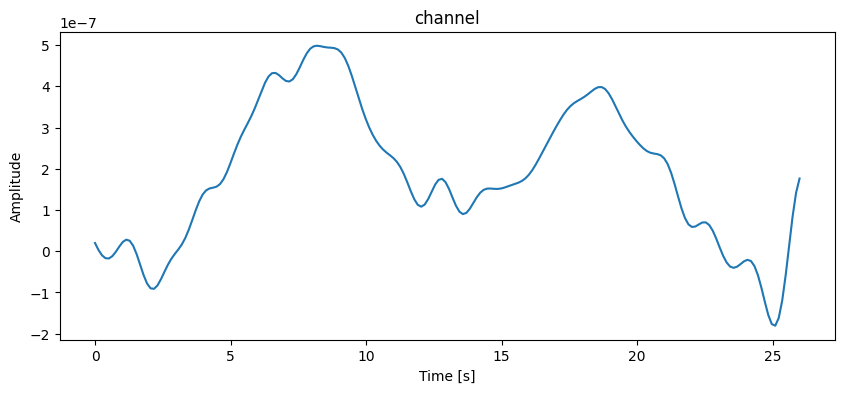

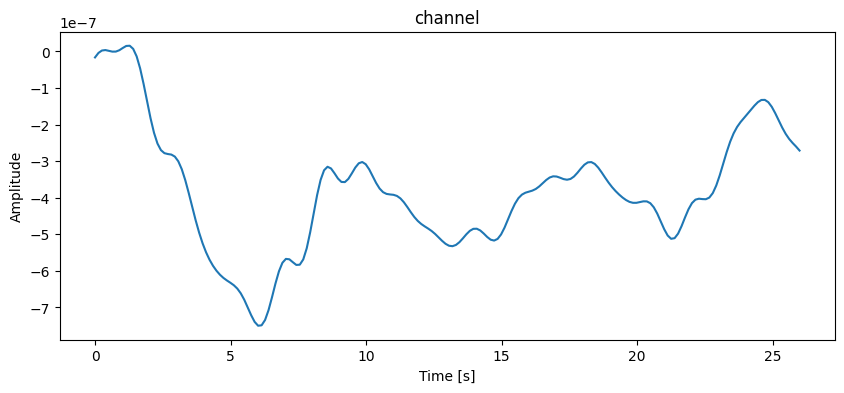

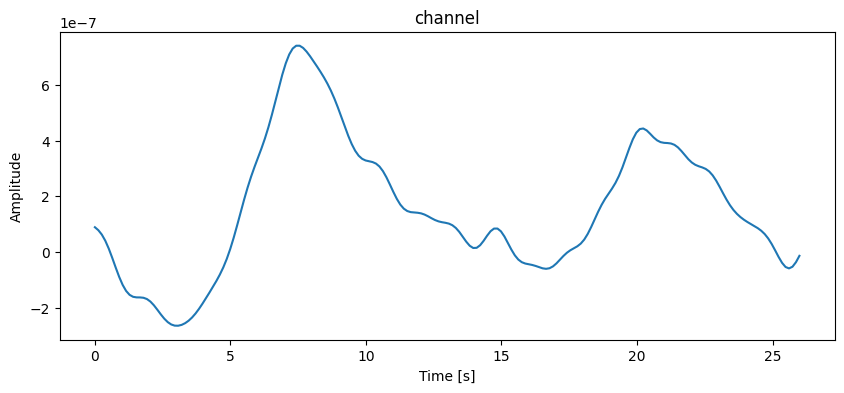

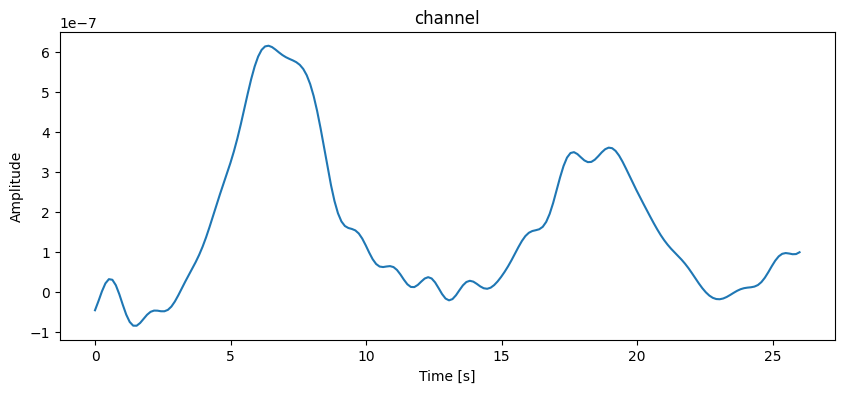

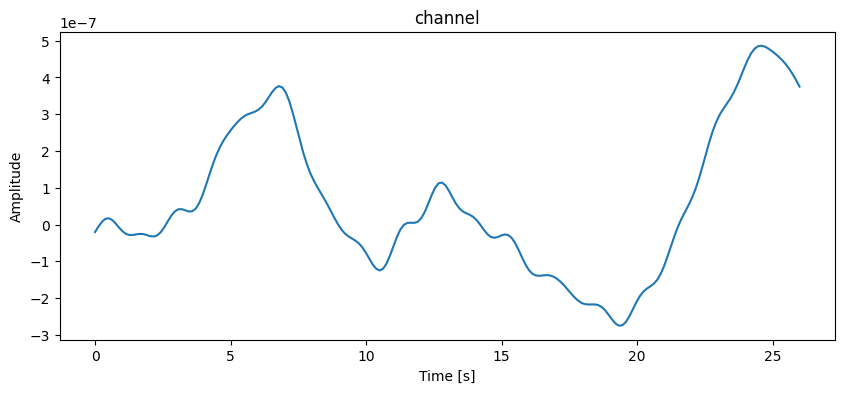

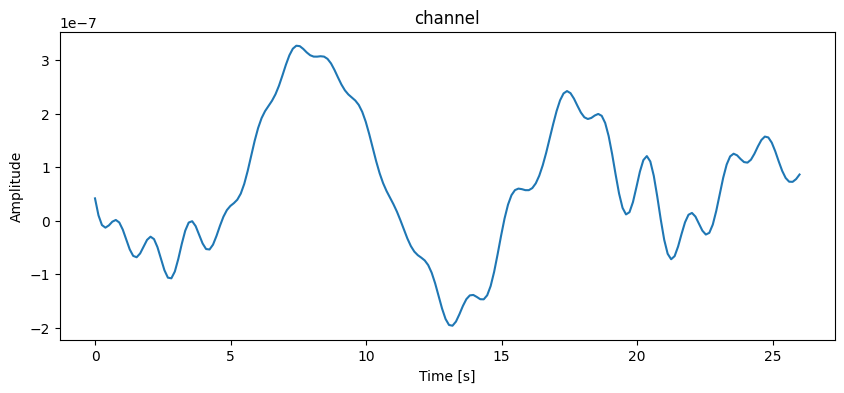

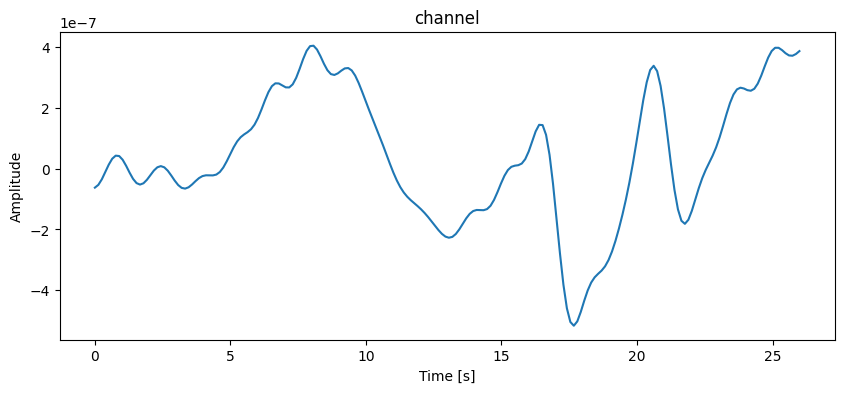

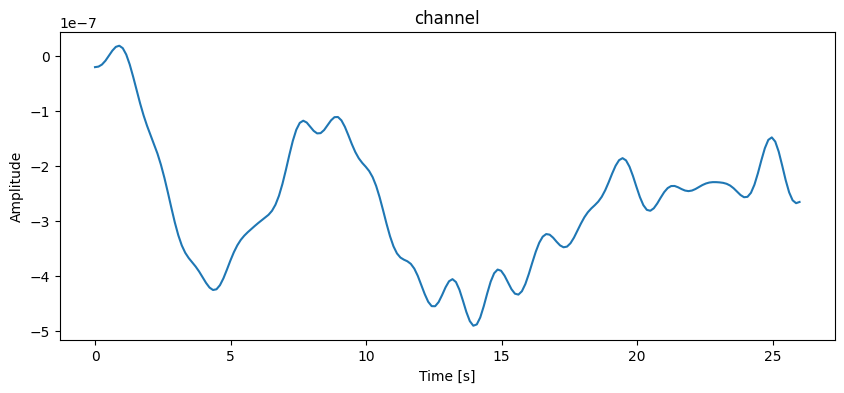

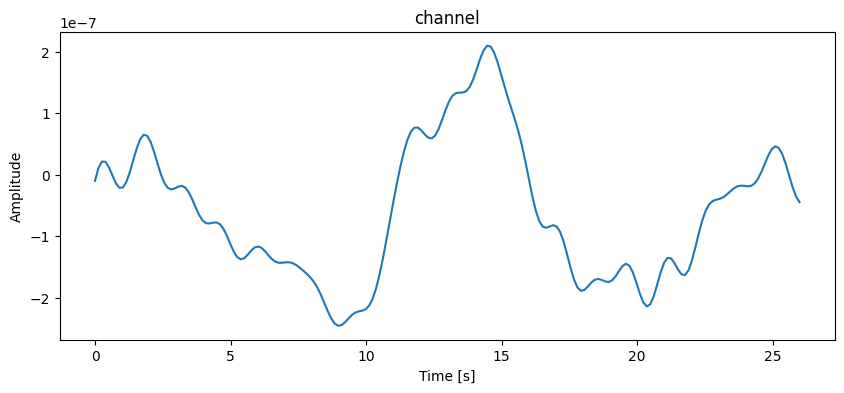

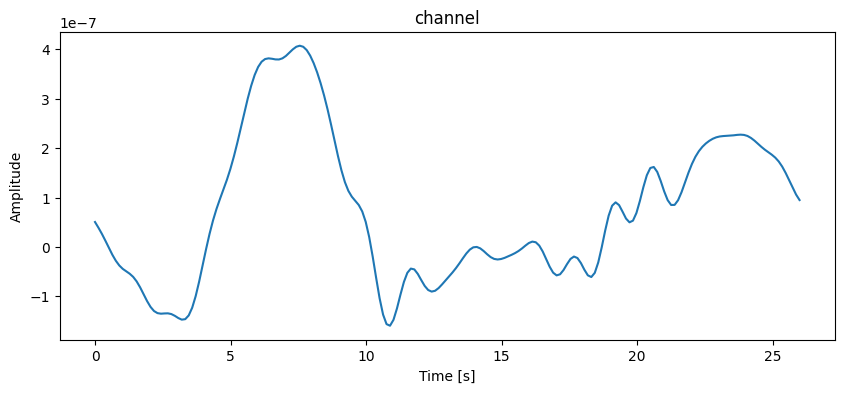

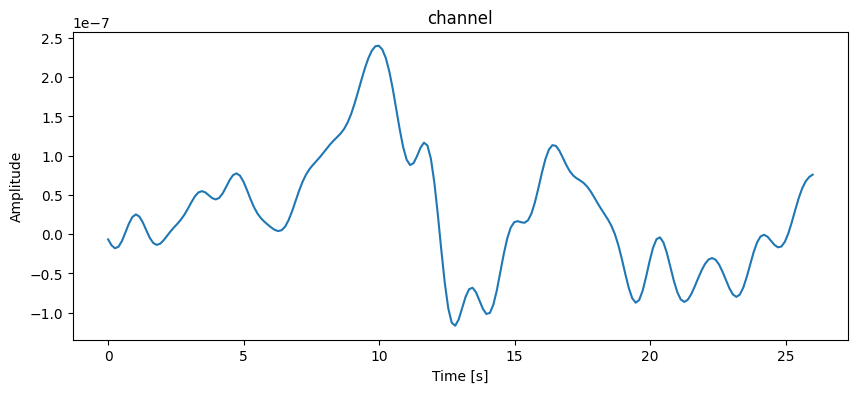

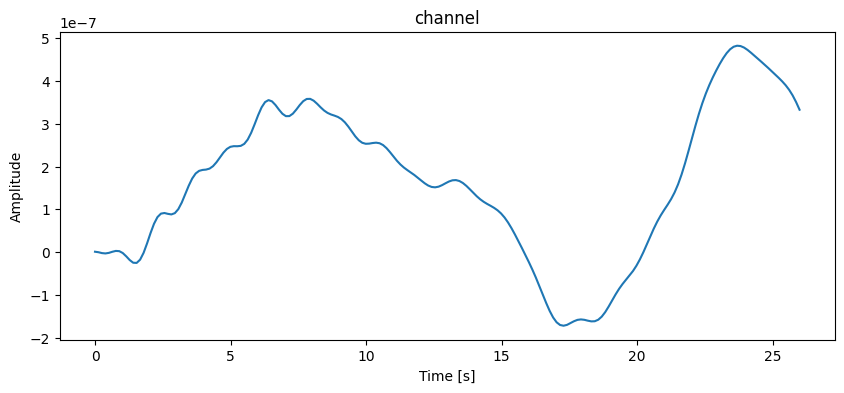

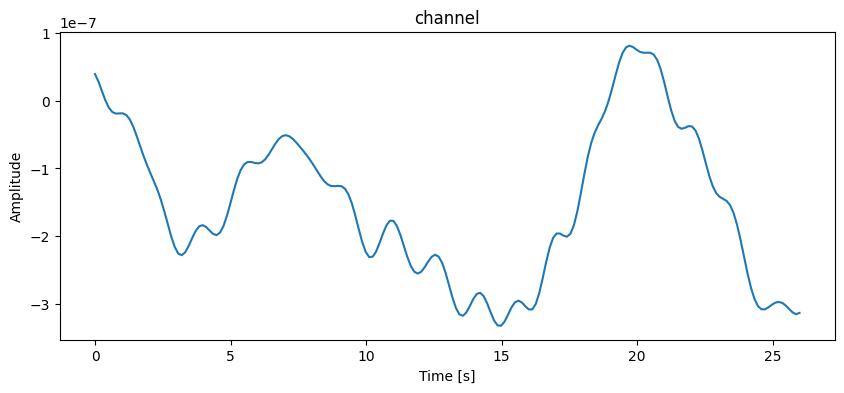

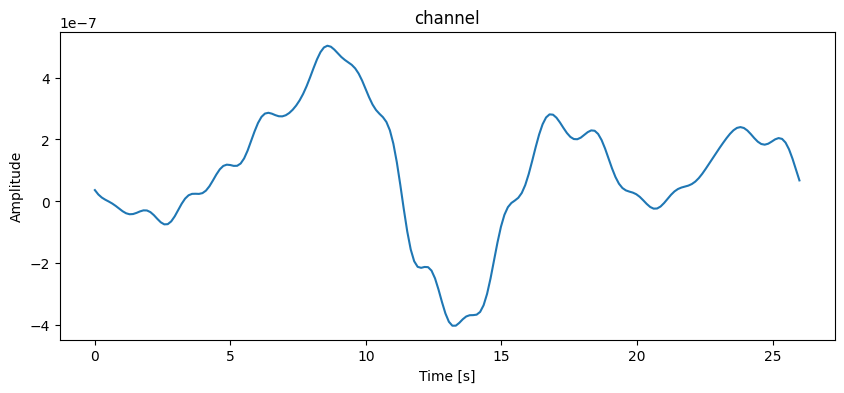

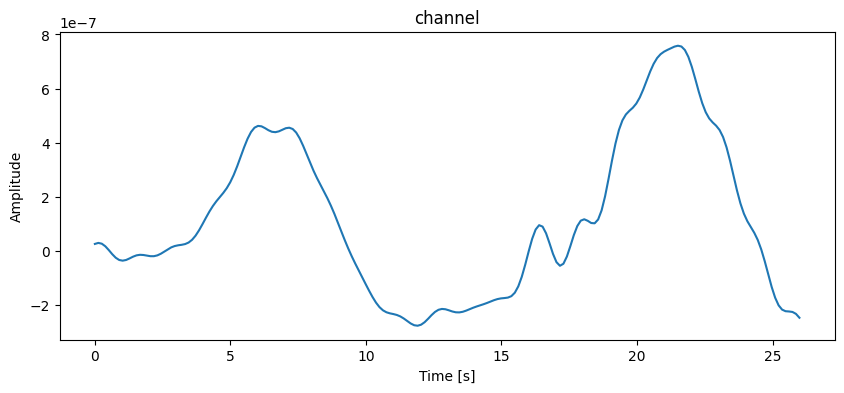

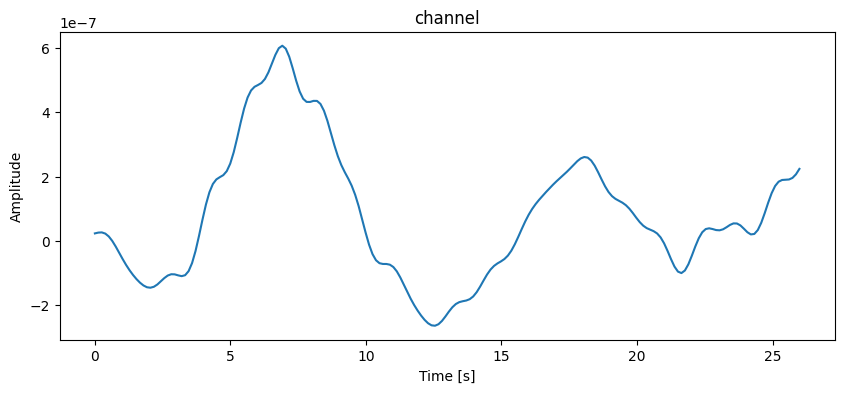

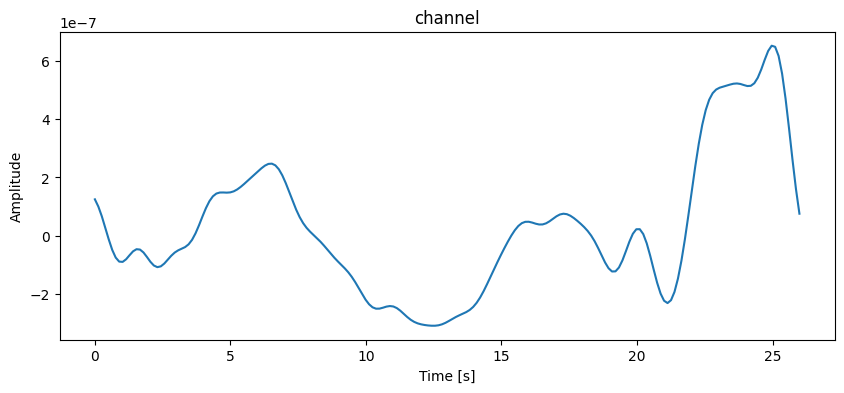

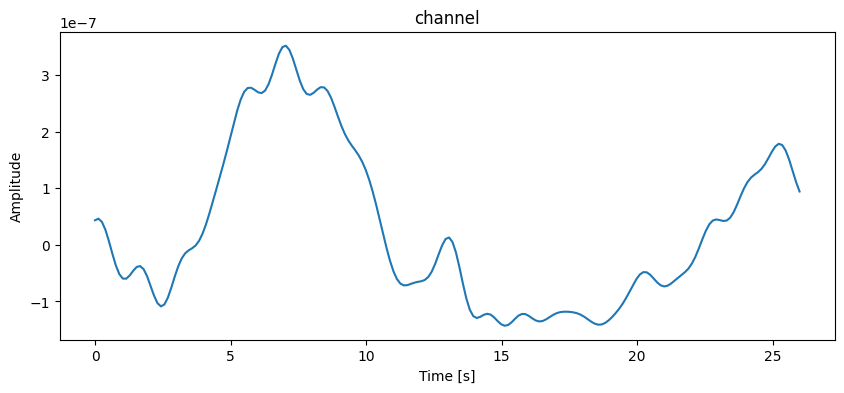

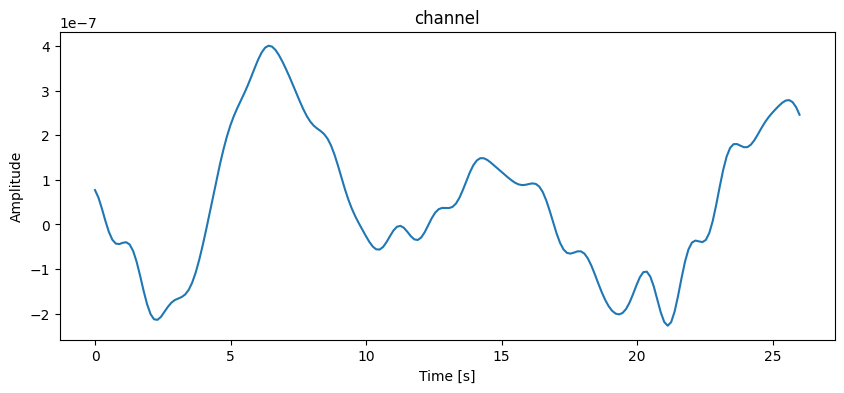

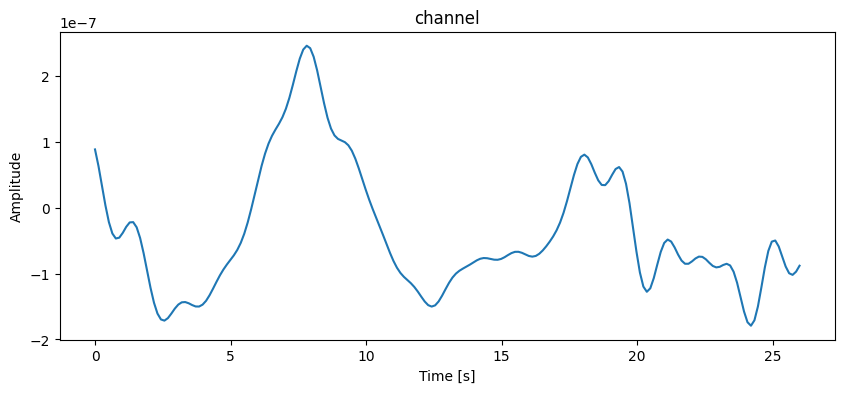

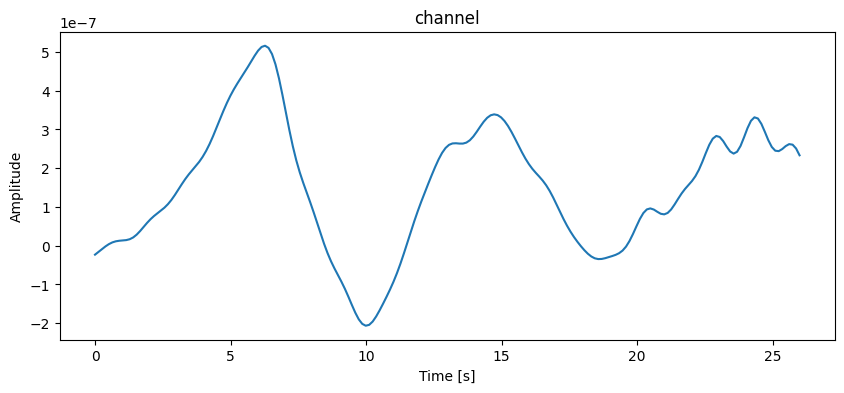

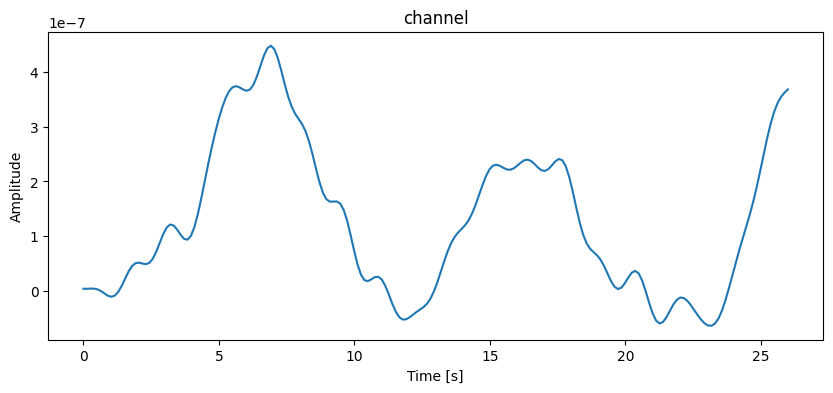

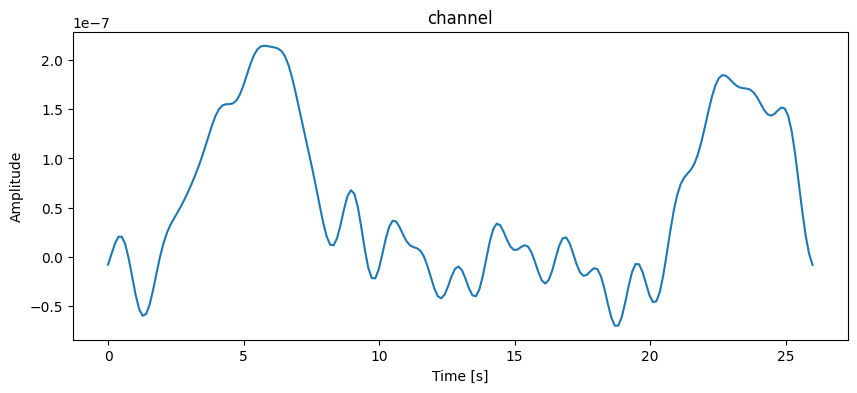

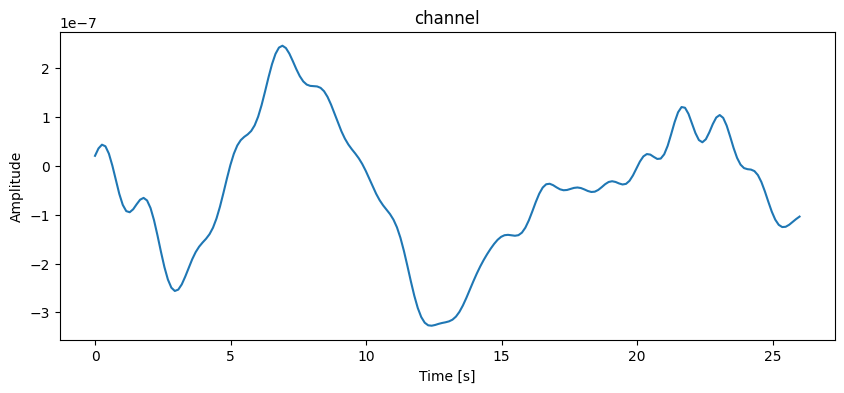

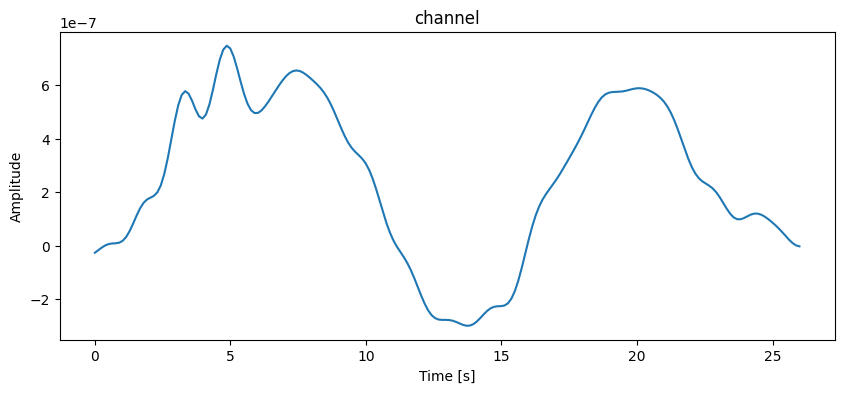

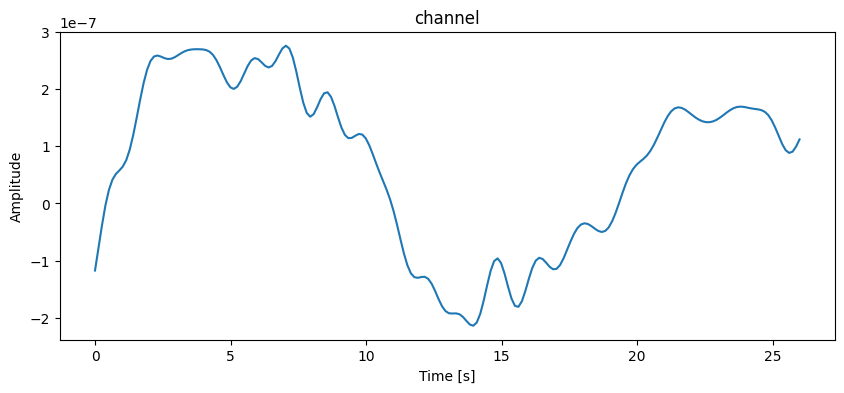

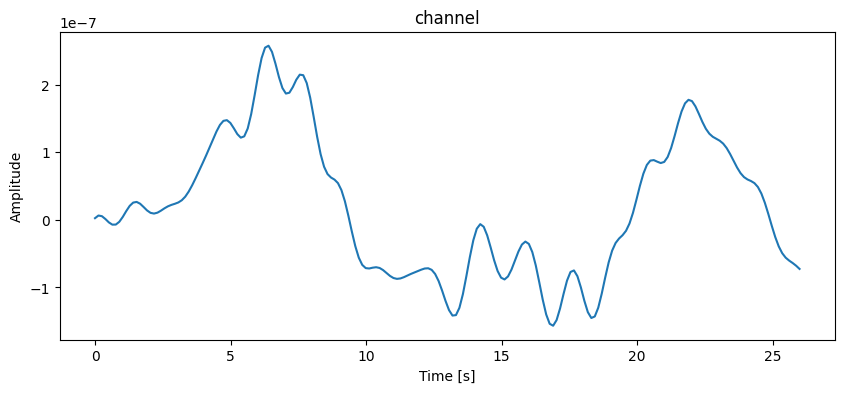

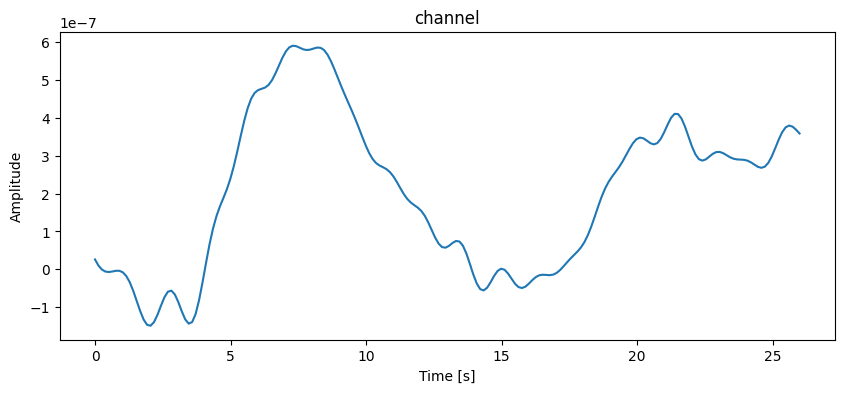

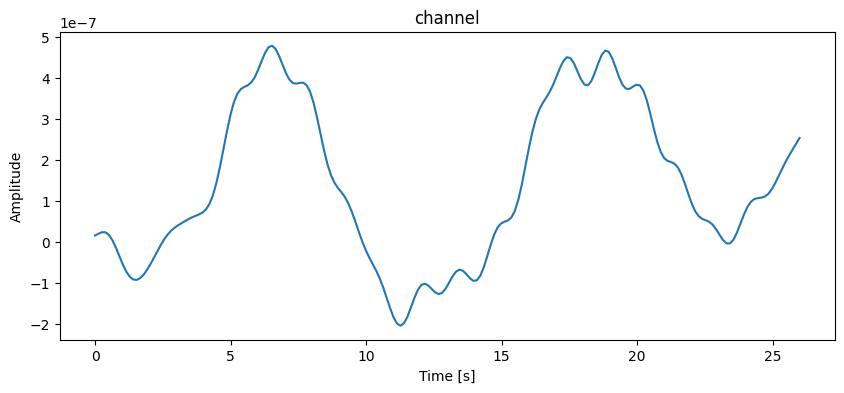

In [495]:
for event in isol_dhrf_data:
    displays.plot_pChannel(event[0], time_signal)

random 8


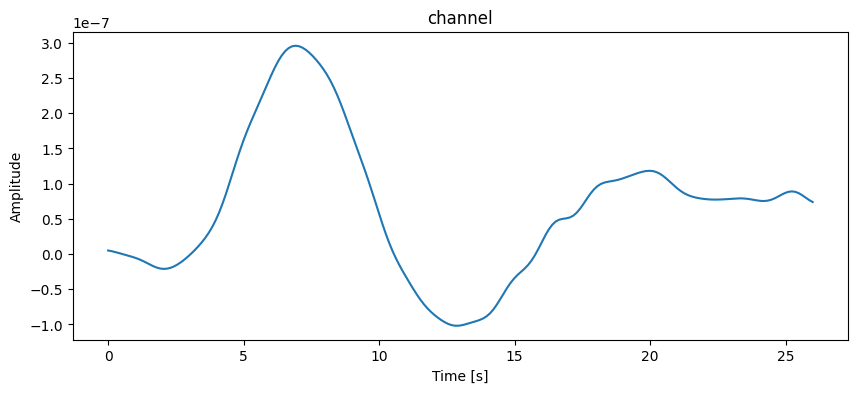

in


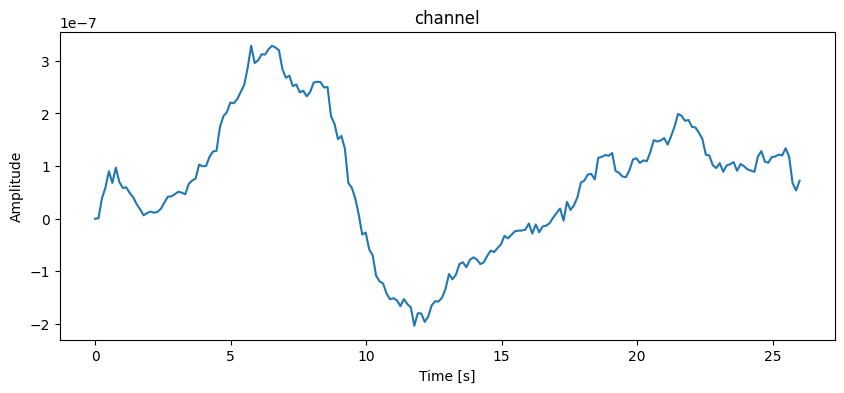

lin


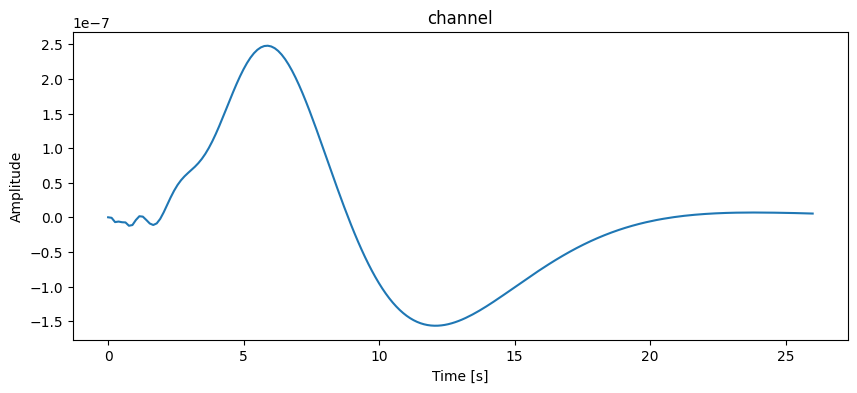

con


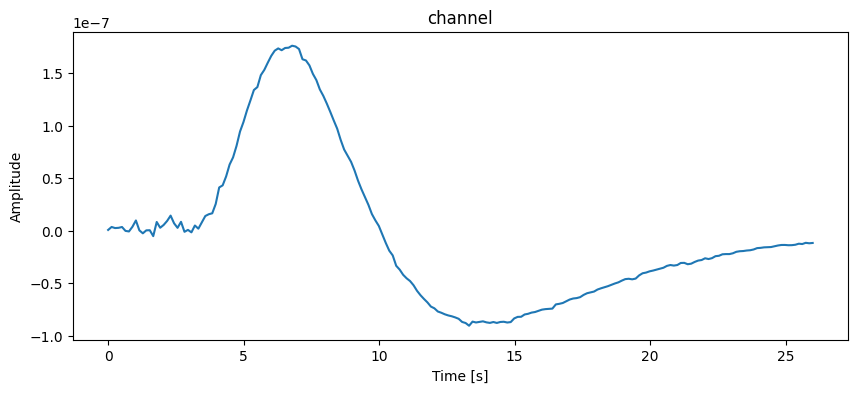

In [510]:
randon = 8#random.randint(0, len(isol_dhrf_data))
print("random", randon)
displays.plot_pChannel(avg_haemo_func_tapping.data[0], time_signal)


r_noise = models.generate_phony_signal(204)
r_avg_overlay = r_noise + avg_haemo_func_tapping.data[0]

with torch.no_grad():
    input_signal = torch.tensor((r_avg_overlay-z_mean)/z_std, dtype=torch.float32).view(1, -1)
    input_signal_conv = torch.tensor((test_overlay[random_number]-z_mean)/z_std, dtype=torch.float32).view(1, -1)

    reconstructed_lin_signal = amp_lin_model(input_signal).numpy().flatten()
    reconstructed_conv_signal = amp_con_model(input_signal_conv).numpy().flatten()

print("in")
displays.plot_pChannel(convs.inv_z_curve_normalisation(input_signal[0], z_mean, z_std), time_signal)
print("lin")
displays.plot_pChannel(convs.inv_z_curve_normalisation(reconstructed_lin_signal, z_mean, z_std), time_signal)
print("con")
displays.plot_pChannel(convs.inv_z_curve_normalisation(reconstructed_conv_signal, z_mean, z_std), time_signal)